# **MACHINE LEARNING PIPELINE**

**Developed by Group 4:**
 - Catarina Monteiro, up202105279
 - Beatriz Silva, up202107955

**Course:** Large Scale Data Science

# **Introduction**

The central theme of this project is centered around the analysis and prediction of patient data collected during their stay in the Intensive Care Unit (ICU). The primary dataset, provided in the EVENTS.csv.gz file, contains extensive records of various events related to ICU patients. This compressed file is approximately 4.2 Gigabytes in size. Our objective is to conduct a comprehensive data analysis and apply machine learning techniques to glean insights from this data. Specifically, we aim to carry out statistical analyses and data visualizations for each patient (denoted by SUBJECT_ID), keeping in mind that a single patient can have multiple hospital admissions (denoted by HADM_ID).

Following our professor’s recommendation, we focused on a single disease to streamline our analysis and prediction efforts. We identified the most recurrent disease within the dataset. All tables were stored in Google BigQuery for efficient querying and management.

During the project, we selected and analyzed several key columns that we deemed most relevant for our work. The merging of these columns into a new table resulted in a BigQuery table format, which posed challenges when using other tools like ApacheSpark, Dask, etc., as these tools require a CSV file for processing.

Therefore, we conducted a comprehensive analysis using only BigQuery and BigFrames.pandas. The final table contained over 4 billion rows. By exporting this table through Google Sheets, we were able to convert it into a CSV file, albeit containing only 500 rows out of the original 4 billion. This limited sample allowed us to perform some level of analysis using the desired tools, albeit less accurately. This approach enabled us to apply and practice the knowledge we gained and to produce a more complete project.

# **Installations**

In [1]:
!pip install --upgrade bigframes
!pip install dask dask-bigquery google-cloud-bigquery


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.6/565.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: bigframes
    Found existing installation: bigframes 1.6.0
    Uninstalling bigframes-1.6.0:
      Successfully uninstalled bigframes-1.6.0


In [2]:
!pip install modin
!pip install google-cloud-bigquery
!pip install spark-bigquery-connector


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
ERROR: Could not find a version that satisfies the requirement spark-bigquery-connector (from versions: none)
ERROR: No matching distribution found for spark-bigquery-connector


In [3]:
!pip install --upgrade pandas==2.2.*


# **Imports**

In [5]:
import bigframes as bf
import bigframes.pandas as bpd

In [6]:
import pandas as pd
import dask.dataframe as dd

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, mean as count, when, udf, regexp_replace, coalesce, lit
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [4]:
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns

# **Configurations**

In [9]:
bf.options.bigquery.projetc="cdl-pratica"
bf.options.bigquery.location="us-central1"

# **Visualization of the datasets found important**
We performed an analysis of several chosen tables, meticulously selecting (on the section "Junction of the columns of the tables found important") the columns that were most relevant to our study. This selection process was crucial for focusing our efforts on the most informative aspects of the data, ensuring that our visualizations would provide meaningful insights.

For our analysis of the **Chartevents** table, we focused on the following relevant columns:

*  **SUBJECT_ID**: This column uniquely identifies each patient.
*  **HADM_ID**: Is unique to a patient hospital stay.
*  **ICUSTAY_ID**: Is unique to a patient ICU stay.
*  **ITEMID**: This column identifies a specific medical measurement or evaluation applied to the patient.
*  **VALUE**: Contains the value measured for the concept identified by the ITEMID.
*  **VALUENUM**: If VALUE is numeric, then VALUENUM contains the same data in a numeric format. If this data is not numeric, VALUENUM is null.
*  **WARNING, ERROR**: WARNING and ERROR are Metavision specific columns which specify if a warning for the value was raised and if an error occurred during the measurement.

In [10]:
chartevents=bpd.read_gbq("cdl-pratica.Data.chartevents")
chartevents

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSSTATUS,STOPPED
0,89665332,10724,164826,231067,3652,2185-06-10 15:30:00,2185-06-10 16:15:00,16660,98,98,Deg F,<NA>,<NA>,<NA>,NotStopd
1,271155005,40548,168670,260223,223901,2156-08-09 08:00:00,2156-08-09 12:43:00,19463,Obeys Commands,6,<NA>,0,0,<NA>,<NA>
2,85506333,9960,159243,200036,550,2181-08-29 03:00:00,2181-08-29 04:02:00,18592,Universal,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,183524860,30310,121631,282905,171,2108-11-16 17:00:00,2108-11-16 19:45:00,15630,Cough/DeepBreath,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
4,74709283,7731,125193,287285,32,2178-02-28 01:00:00,2178-02-28 03:25:00,21570,Tolerated Well,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
5,161747143,25368,146404,233582,618,2128-09-17 17:00:00,2128-09-17 17:02:00,15283,24,24,BPM,<NA>,<NA>,<NA>,NotStopd
6,224304991,31044,184171,204730,5820,2121-05-04 19:00:00,2121-05-04 19:11:00,16302,90,90,%,<NA>,<NA>,<NA>,NotStopd
7,24361814,78532,177956,240761,224150,2159-05-08 03:00:00,2159-05-08 06:45:00,17574,176,176,mmHg,0,0,<NA>,<NA>
8,54287556,3868,157650,269518,211,2125-09-13 07:00:00,2125-09-13 07:30:00,17189,87,87,BPM,<NA>,<NA>,<NA>,NotStopd
9,135859715,19942,190227,213176,683,2164-07-27 12:00:00,2164-07-27 12:04:00,18795,500,500,ml/B,<NA>,<NA>,<NA>,NotStopd


**ICUSTAYS:**
*   **SUBJECT_ID**
*  **HADM_ID**
*   **LOS:**  LOS is the length of stay for the patient for the given ICU stay, which may include one or more ICU units. The length of stay is measured in fractional days.

In [11]:
icustays=bpd.read_gbq("cdl-pratica.Data.icustays")
icustays

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,11127,8744,175078,230090,carevue,NICU,NICU,56,56,2137-01-22 22:20:47+00:00,2137-01-23 00:57:15+00:00,0.1087
1,5359,4223,122294,227863,carevue,MICU,MICU,52,52,2152-04-07 20:05:14+00:00,2152-04-09 18:04:39+00:00,1.9163
2,59268,93362,187375,234826,metavision,CSRU,CSRU,12,12,2134-01-18 10:56:44+00:00,2134-01-19 15:48:39+00:00,1.2027
3,5045,3977,111024,203161,carevue,MICU,MICU,15,15,2141-05-04 18:55:56+00:00,2141-05-06 17:33:04+00:00,1.9425
4,9239,7255,180181,293531,carevue,CCU,CCU,57,57,2173-06-21 14:21:11+00:00,2173-06-25 19:00:47+00:00,4.1942
5,23434,18490,166658,211034,carevue,MICU,MICU,50,50,2105-07-23 03:50:56+00:00,2105-07-24 15:02:32+00:00,1.4664
6,46837,56116,131774,254007,metavision,TSICU,TSICU,14,14,2121-01-22 14:29:09+00:00,2121-01-23 18:01:45+00:00,1.1476
7,53805,76736,113085,212477,metavision,MICU,MICU,52,52,2168-03-26 03:04:39+00:00,2168-03-26 19:43:53+00:00,0.6939
8,3703,2948,158914,263205,carevue,MICU,MICU,12,12,2129-11-12 00:21:25+00:00,2129-11-14 18:06:28+00:00,2.7396
9,36184,28557,178081,296366,carevue,CSRU,CSRU,15,12,2129-05-18 11:22:43+00:00,2129-05-19 10:51:58+00:00,0.9786


**D_Items:**


*   **ITEMID**
*   **DBSOURCE:** The DBSOURCE column was generated to clarify which database the given ITEMID was sourced from: ‘carevue’ indicates the ITEMID was sourced from CareVue, while ‘metavision’ indicated the ITEMID was sourced from Metavision.
*   **LABEL:** The LABEL column describes the concept which is represented by the ITEMID


In [12]:
d_items=bpd.read_gbq("cdl-pratica.Data.d_items")
d_items

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,14366,225929,ProBalance (Full),ProBalance (Full),metavision,inputevents_mv,Nutrition - Enteral,mL,Solution,<NA>
1,4881,8418,Inc #3 [Appearance],<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,13689,225312,ART BP mean,ART BP mean,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,<NA>
3,10152,45902,SSC30NG,<NA>,carevue,inputevents_cv,Free Form Intake,<NA>,<NA>,<NA>
4,15060,227962,Restraints (Violent),Restraints (Violent),metavision,chartevents,Restraint/Support Systems,<NA>,Text,<NA>
5,4451,6952,Aprotinen,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
6,2634,6238,propofol,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
7,9349,46169,free water bolus.,<NA>,carevue,inputevents_cv,Free Form Intake,<NA>,<NA>,<NA>
8,4555,7209,COUGH/DEEP BREATHING,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
9,12950,221212,"Saline 0,18%","Saline 0,18%",metavision,inputevents_mv,Fluids - Other (Not In Use),mL,Solution,<NA>


**Patients:**


*   **SUBJECT_ID**
*   **DOB:** is the date of birth of the given patient.
*   **GENDER:** is the genotypical sex of the patient.

In [13]:
patients=bpd.read_gbq("cdl-pratica.Data.patients")
patients

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33252,49367,F,2092-03-30 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,2642,2793,F,1887-04-13 00:00:00+00:00,2187-04-18 00:00:00+00:00,2187-04-18 00:00:00+00:00,2187-04-18 00:00:00+00:00,1
2,23066,24444,M,2104-09-05 00:00:00+00:00,2168-09-03 00:00:00+00:00,2168-09-03 00:00:00+00:00,2168-09-03 00:00:00+00:00,1
3,15423,16312,M,2118-09-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
4,29140,31000,F,2099-01-04 00:00:00+00:00,2176-11-16 00:00:00+00:00,2176-11-16 00:00:00+00:00,2176-11-16 00:00:00+00:00,1
5,37722,66109,F,2103-12-15 00:00:00+00:00,<NA>,<NA>,<NA>,0
6,38364,68601,F,2118-11-23 00:00:00+00:00,<NA>,<NA>,<NA>,0
7,37341,64752,F,1862-06-23 00:00:00+00:00,<NA>,<NA>,<NA>,0
8,8597,9083,M,2153-10-30 00:00:00+00:00,<NA>,<NA>,<NA>,0
9,18105,19170,F,2145-03-18 00:00:00+00:00,<NA>,<NA>,<NA>,0


**Admissions:**

*   **ADMISSION_TYPE:** Describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’.
*   **ADMITTIME:** Provides the date and time the patient was admitted to the hospital
*   **DISCHTIME:** Provides the date and time the patient was discharged from the hospital.
*   **DEATHTIME:** If applicable, DEATHTIME provides the time of in-hospital death for the patient.
*    **INSURANCE**
*   **LANGUAGE**
*   **RELIGION**
*   **MARITAL_STATUS**
*   **ETHNICITY**
The INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY columns describe patient demographics.
*   **HOSPITAL_EXPIRE_FLAG:** This indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge.

In [14]:
admissions=bpd.read_gbq("cdl-pratica.Data.admissions")
admissions

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,13085,10699,131811,2185-05-31 10:20:00+00:00,2185-07-11 12:15:00+00:00,<NA>,NEWBORN,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Private,<NA>,CATHOLIC,<NA>,WHITE,<NA>,<NA>,NEWBORN,0,1
1,5542,4587,198345,2150-05-19 11:01:00+00:00,2150-05-21 15:01:00+00:00,2150-05-21 15:01:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,<NA>,CATHOLIC,MARRIED,WHITE,2150-05-19 03:19:00+00:00,2150-05-19 10:45:00+00:00,SEPSIS;HYPOXIA,1,1
2,28638,23467,101328,2169-08-02 17:08:00+00:00,2169-08-04 16:14:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,<NA>,JEWISH,<NA>,WHITE,<NA>,<NA>,NEWBORN,0,1
3,27285,22362,148514,2117-01-21 12:54:00+00:00,2117-01-28 13:20:00+00:00,<NA>,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Medicaid,<NA>,PROTESTANT QUAKER,<NA>,WHITE,<NA>,<NA>,NEWBORN,0,1
4,51357,76116,170491,2164-10-08 12:36:00+00:00,2164-10-12 16:30:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Private,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,2164-10-08 08:40:00+00:00,2164-10-08 13:05:00+00:00,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,0,1
5,35700,29277,111703,2167-10-17 11:15:00+00:00,2167-10-19 13:15:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Government,ENGL,CHRISTIAN SCIENTIST,SINGLE,BLACK/AFRICAN AMERICAN,<NA>,<NA>,NEWBORN,0,1
6,25534,20925,133360,2139-04-02 07:15:00+00:00,2139-04-15 13:20:00+00:00,<NA>,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,<NA>,PROTESTANT QUAKER,MARRIED,WHITE,<NA>,<NA>,BLADDER CA/SDA,0,1
7,9568,7809,149867,2133-01-07 04:14:00+00:00,2133-01-11 16:58:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,ENGL,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,2133-01-06 23:22:00+00:00,2133-01-07 05:54:00+00:00,DIABETIC KETOACIDOSIS,0,1
8,7252,5921,128142,2159-01-01 01:51:00+00:00,2159-01-11 19:03:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,CAPE,<NA>,SINGLE,UNKNOWN/NOT SPECIFIED,2159-01-01 00:06:00+00:00,2159-01-01 02:30:00+00:00,S/P MOTOR VEHICLE ACCIDENT,0,1
9,36849,30253,170829,2150-08-20 12:02:00+00:00,2150-08-26 13:42:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2150-08-20 09:08:00+00:00,2150-08-20 13:28:00+00:00,HYPOGLYCEMIA,0,1


**D_icd_diagnoses:**
*   **ICD9_CODE:** is the International Coding Definitions Version 9 (ICD-9) code. Each code corresponds to a single diagnostic concept.
*   **LONG_TITLE**
*   **SHORT_TITLE**

The title fields provide a brief definition for the given diagnosis code in ICD9_CODE.

In [15]:
d_icd_diagnoses=bpd.read_gbq("cdl-pratica.Data.d_icd_diagnoses")
d_icd_diagnoses

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,3968,36253,Cystoid macular degen,Cystoid macular degeneration
1,7447,82390,Fx tibia NOS-open,Open fracture of unspecified part of tibia alone
2,8447,71292,Cryst arthrop NOS-up/arm,"Unspecified crystal arthropathy, upper arm"
3,11765,8700,Lac eyelid skn/perioculr,Laceration of skin of eyelid and periocular area
4,10292,81200,Fx up end humerus NOS-cl,Closed fracture of unspecified part of upper e...
5,12364,99709,Surg comp nerv systm NEC,Other nervous system complications
6,10199,V4983,Await organ transplnt st,Awaiting organ transplant status
7,169,01161,TB pneumonia-no exam,"Tuberculous pneumonia [any form], bacteriologi..."
8,5750,6254,Premenstrual tension,Premenstrual tension syndromes
9,6137,53989,Ot comp ot bariatrc proc,Other complications of other bariatric procedure


**Diagnoses_icd:**
Contains ICD diagnoses for patients.
*   **ICD9_CODE**
*   **SUBJECT_ID**

In [16]:
diagnoses_icd = bpd.read_gbq("cdl-pratica.Data.diagnoses_icd")
diagnoses_icd

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,436671,52592,136506,6,4111
1,365507,31765,194985,1,9941
2,219842,19689,180660,6,41401
3,224476,20124,148251,2,5856
4,503588,67069,104665,15,412
5,287989,25724,196248,1,41001
6,323810,28531,170966,7,57400
7,61192,5476,100343,5,51881
8,373988,32426,103254,21,V4364
9,192812,17288,123138,7,49390



**Callout**

*   **CALLOUT_OUTCOME**: Is either ‘Discharged’ or ‘Cancelled’, indicating whether the patient finally called out (i.e. discharged) or not.
*   **CREATETIME:** Provides the time and date that the call out was initiated.
*   **OUTIME:**  Is the time at which the CALLOUT_OUTCOME occurred.









In [17]:
callout = bpd.read_gbq("cdl-pratica.Data.callout")
callout

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,16191,41077,105605,57,<NA>,18,SICU,18,OMED,1,...,Inactive,Discharged,18,Acknowledged,2199-09-03 18:25:39+00:00,2199-09-03 20:02:49+00:00,2199-09-03 20:20:47+00:00,2199-09-04 11:10:29+00:00,2199-09-03 18:41:38+00:00,<NA>
1,14873,31664,166237,7,CCU,7,CCU,1,MED,0,...,Inactive,Cancelled,<NA>,Acknowledged,2186-11-06 12:35:12+00:00,2186-11-06 14:10:26+00:00,2186-11-06 12:52:37+00:00,2186-11-06 14:10:26+00:00,<NA>,<NA>
2,27994,78708,128524,23,<NA>,45,MICU,1,MED,0,...,Inactive,Discharged,45,Acknowledged,2177-02-16 14:15:26+00:00,2177-02-16 14:49:22+00:00,2177-02-16 14:49:38+00:00,2177-02-16 17:56:39+00:00,2177-02-16 15:11:51+00:00,<NA>
3,923,2338,184485,7,<NA>,17,CCU,17,CMED,1,...,Inactive,Discharged,17,Acknowledged,2159-09-17 09:51:58+00:00,2159-09-17 09:51:58+00:00,2159-09-17 10:18:27+00:00,2159-09-17 18:25:19+00:00,2159-09-17 16:25:22+00:00,<NA>
4,5136,13174,187906,23,<NA>,4,MICU,1,MED,1,...,Inactive,Discharged,4,Acknowledged,2184-07-16 09:46:38+00:00,2184-07-16 09:46:38+00:00,2184-07-16 11:11:33+00:00,2184-07-16 18:25:02+00:00,<NA>,<NA>
5,17705,46022,155140,14,<NA>,36,TSICU,1,SURG,0,...,Inactive,Discharged,36,Acknowledged,2155-10-10 10:19:03+00:00,2155-10-10 10:19:03+00:00,2155-10-10 10:19:21+00:00,2155-10-10 19:10:20+00:00,2155-10-10 18:10:22+00:00,<NA>
6,5350,13719,197340,7,<NA>,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2148-12-01 10:22:02+00:00,2148-12-01 10:22:02+00:00,2148-12-01 11:20:19+00:00,2148-12-01 16:55:04+00:00,<NA>,<NA>
7,1508,3917,143161,7,<NA>,4,CCU,1,MED,0,...,Inactive,Discharged,4,Acknowledged,2102-09-12 09:58:55+00:00,2102-09-12 09:58:55+00:00,2102-09-12 10:37:33+00:00,2102-09-12 17:55:02+00:00,<NA>,<NA>
8,27774,77947,150417,50,<NA>,45,MICU,1,MED,0,...,Inactive,Discharged,45,Acknowledged,2115-08-04 10:44:37+00:00,2115-08-05 13:45:37+00:00,2115-08-05 13:45:40+00:00,2115-08-05 16:25:24+00:00,2115-08-05 14:40:27+00:00,<NA>
9,22298,60174,102821,52,MICU,52,MICU,1,MED,0,...,Inactive,Cancelled,<NA>,Acknowledged,2169-08-27 18:34:57+00:00,2169-08-28 05:10:14+00:00,2169-08-27 18:47:31+00:00,2169-08-28 05:10:14+00:00,2169-08-28 00:25:09+00:00,<NA>


# **Obtain the disease which has more occurencies**
In this section, we investigate which disease occurs most frequently in the dataset.

In [18]:
# Reading data from the 'diagnoses_icd' table in Google BigQuery and storing it in the 'diagnoses_icd' dataframe
diagnoses_icd = bpd.read_gbq("cdl-pratica.Data.diagnoses_icd")

# Counting the occurrences of each unique value in the 'ICD9_CODE' column and storing the result in the 'diagnoses_counts' Series
diagnoses_counts = diagnoses_icd['ICD9_CODE'].value_counts()

# Finding the most common disease code by getting the index (disease code) of the maximum count in 'diagnoses_counts'
most_common_disease_code = diagnoses_counts.idxmax()

# Getting the maximum count of occurrences from 'diagnoses_counts'
most_common_disease_count = diagnoses_counts.max()

# Printing the most common disease code and its count
print(f"The most common disease code is: {most_common_disease_code} and it occurs {most_common_disease_count} times.")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2024-06-08 19:29:33.909912+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


The most common disease code is: 4019 and it occurs 20703 times.


In [19]:
# Reading data from the 'd_icd_diagnoses' table in Google BigQuery and storing it in the 'd_icd_diagnoses' dataframe
d_icd_diagnoses = bpd.read_gbq("cdl-pratica.Data.d_icd_diagnoses")

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2024-06-08 19:29:25.955717+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
# Filtering rows in the 'd_icd_diagnoses' dataframe where the 'ICD9_CODE' column equals '4019'
filtered_row = d_icd_diagnoses[d_icd_diagnoses['ICD9_CODE'] == '4019']

# Extracting the value of the 'SHORT_TITLE' column from the filtered row and storing it in 'short_title_value'
short_title_value = filtered_row['SHORT_TITLE'].values[0]

# Printing the value of 'short_title_value'
print(short_title_value)

Hypertension NOS


# **Analysis and Prediction of Hospital Stays for Patients with Hypertension NOS**

# **Junction of the columns of the tables found important**

To streamline our analysis and modeling process, we merged the selected columns from the relevant tables into a single unified dataset. This consolidated dataset contains the essential information required for our study on patients with Hypertension NOS and their hospital stays.

In [21]:
# SQL query to select specific columns from the 'diagnoses_icd' and 'd_icd_diagnoses' tables,
# joining them on the 'ICD9_CODE' column to retrieve short and long titles for each diagnosis code
query = """
SELECT
  di.SUBJECT_ID,
  di.HADM_ID,
  di.SEQ_NUM,
  di.ICD9_CODE,
  d.SHORT_TITLE,
  d.LONG_TITLE
FROM
  cdl-pratica.Data.diagnoses_icd AS di
JOIN
  cdl-pratica.Data.d_icd_diagnoses AS d
ON
  di.ICD9_CODE = d.ICD9_CODE
"""

# Executing the SQL query and storing the results in the 'df_diagnoses' dataframe
df_diagnoses = bpd.read_gbq(query, use_cache=False)

# Displaying the resulting dataframe
df_diagnoses

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,66643,178527,19,3659,Glaucoma NOS,Unspecified glaucoma
1,40695,148810,6,5990,Urin tract infection NOS,"Urinary tract infection, site not specified"
2,25314,177523,19,99592,Severe sepsis,Severe sepsis
3,93431,150045,7,496,Chr airway obstruct NEC,"Chronic airway obstruction, not elsewhere clas..."
4,21514,179269,7,53081,Esophageal reflux,Esophageal reflux
5,56106,123298,9,42731,Atrial fibrillation,Atrial fibrillation
6,24825,136162,7,4168,Chr pulmon heart dis NEC,Other chronic pulmonary heart diseases
7,72545,123167,9,58381,Nephritis NOS in oth dis,"Nephritis and nephropathy, not specified as ac..."
8,24224,164126,3,0389,Septicemia NOS,Unspecified septicemia
9,24903,165767,9,2760,Hyperosmolality,Hyperosmolality and/or hypernatremia


In [22]:
# SQL query to select various features from different tables, joining them on common keys where applicable
query2 = """
SELECT
  char.SUBJECT_ID,
  char.HADM_ID,
  char.ICUSTAY_ID,
  p.DOB,
  adm.ADMITTIME,
  adm.DISCHTIME,
  adm.DEATHTIME,
  adm.HOSPITAL_EXPIRE_FLAG,
  adm.ADMISSION_TYPE,
  p.GENDER,
  adm.ETHNICITY,
  adm.RELIGION,
  adm.LANGUAGE,
  adm.MARITAL_STATUS,
  adm.INSURANCE,
  call.CALLOUT_OUTCOME,
  call.CREATETIME,
  call.OUTCOMETIME,
  char.ITEMID,
  items.LABEL,
  char.VALUE,
  char.VALUENUM,
  char.WARNING,
  char.ERROR,
  items.DBSOURCE,
  ic.LOS
FROM
  cdl-pratica.Data.chartevents AS char
LEFT JOIN
  cdl-pratica.Data.patients AS p
ON
  CAST(char.SUBJECT_ID AS STRING) = CAST(p.SUBJECT_ID AS STRING)
LEFT JOIN
  cdl-pratica.Data.d_items AS items
ON
  CAST(char.ITEMID AS STRING) = CAST(items.ITEMID AS STRING)
LEFT JOIN
  cdl-pratica.Data.admissions AS adm
ON
  CAST(char.SUBJECT_ID AS STRING) = CAST(adm.SUBJECT_ID AS STRING)
LEFT JOIN
  cdl-pratica.Data.callout AS call
ON
  CAST(char.SUBJECT_ID AS STRING) = CAST(call.SUBJECT_ID AS STRING)
LEFT JOIN
  cdl-pratica.Data.icustays AS ic
ON
  CAST(char.ICUSTAY_ID AS STRING) = CAST(ic.ICUSTAY_ID AS STRING)
"""

# Executing the SQL query and storing the results in the 'all_features' dataframe
all_features = bpd.read_gbq(query2, use_cache=False)

# Displaying the resulting dataframe
all_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,CREATETIME,OUTCOMETIME,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS
0,76327,142755,291918,2106-01-28 00:00:00+00:00,2148-01-02 13:38:00+00:00,2148-01-08 15:00:00+00:00,<NA>,0,EMERGENCY,M,...,2147-12-21 14:45:00+00:00,2147-12-21 18:25:03+00:00,225640,Differential-Eos,.5,.5,0,0,metavision,4.4359
1,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
2,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
3,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
4,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
5,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
6,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
7,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
8,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223
9,29035,154213,239972,2089-12-13 00:00:00+00:00,2156-02-14 16:44:00+00:00,2156-03-04 15:45:00+00:00,<NA>,0,EMERGENCY,F,...,2152-08-14 22:05:14+00:00,2152-08-15 02:55:03+00:00,224054,Braden Sensory Perception,Slight Impairment,3,0,0,metavision,4.7223


In [23]:
# Writing the 'all_features' dataframe to the 'cdl-pratica.Data.all_features' table in Google BigQuery, replacing it if it already exists
all_features.to_gbq('cdl-pratica.Data.all_features', if_exists='replace')

# Writing the 'df_diagnoses' dataframe to the 'cdl-pratica.Data.df_diagnoses' table in Google BigQuery, replacing it if it already exists
df_diagnoses.to_gbq('cdl-pratica.Data.df_diagnoses', if_exists='replace')

'cdl-pratica.Data.df_diagnoses'

In [24]:
# SQL query to select all features from the 'all_features' table and additional diagnosis-related columns from the 'df_diagnoses' table,
# joining them on the 'SUBJECT_ID' column and filtering rows where the 'ICD9_CODE' column equals '4019'
query3 = """
SELECT
  af.*,
  d.ICD9_CODE,
  d.SHORT_TITLE,
  d.SEQ_NUM
FROM
  cdl-pratica.Data.all_features AS af
LEFT JOIN
  cdl-pratica.Data.df_diagnoses AS d
ON
  CAST(af.SUBJECT_ID AS STRING) = CAST(d.SUBJECT_ID AS STRING)
WHERE
  d.ICD9_CODE = '4019'
"""

# Executing the SQL query and storing the results in the 'raw_features' dataframe
raw_features = bpd.read_gbq(query3, use_cache=False)

# Displaying the resulting dataframe
raw_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
0,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
1,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
2,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
3,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
4,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
5,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
6,11861,144257,298894,2105-05-05 00:00:00+00:00,2132-06-13 01:56:00+00:00,2132-06-15 17:50:00+00:00,<NA>,0,EMERGENCY,F,...,Non Invasive Blood Pressure mean,103,103,0,0,metavision,2.1461,4019,Hypertension NOS,4
7,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21
8,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21
9,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21


In [25]:
# Writing the 'raw_features' dataframe to the 'cdl-pratica.Data.raw_features' table in Google BigQuery, replacing it if it already exists
raw_features.to_gbq('cdl-pratica.Data.raw_features', if_exists='replace')

'cdl-pratica.Data.raw_features'

In [26]:
print(raw_features.columns)

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME', 'ITEMID', 'LABEL',
       'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE', 'LOS', 'ICD9_CODE',
       'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


# **Using BigQuery**

## **Data Pre Processing**
In this section, we conduct an analysis of the dataset, focusing on preprocessing steps such as handling null values and removing duplicate rows. These preprocessing tasks are essential for ensuring the quality and integrity of the data before proceeding with further analysis and modeling.

In [27]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery and storing it in the 'raw_features' dataframe
raw_features = bpd.read_gbq("cdl-pratica.Data.raw_features")

# Displaying the resulting dataframe
raw_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
0,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
1,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
2,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
3,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
4,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
5,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
6,11861,144257,298894,2105-05-05 00:00:00+00:00,2132-06-13 01:56:00+00:00,2132-06-15 17:50:00+00:00,<NA>,0,EMERGENCY,F,...,Non Invasive Blood Pressure mean,103,103,0,0,metavision,2.1461,4019,Hypertension NOS,4
7,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21
8,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21
9,25225,115814,201901,2147-08-13 00:00:00+00:00,2180-04-28 12:05:00+00:00,2180-05-18 15:40:00+00:00,<NA>,0,EMERGENCY,F,...,Braden Mobility,Sl. Limited,<NA>,<NA>,<NA>,carevue,2.8073,4019,Hypertension NOS,21


In [28]:
num_lines, num_col = raw_features.shape
print(f"Number of lines: {num_lines}")
print(f"Number of columns: {num_col}")


Number of lines: 4355563993
Number of columns: 29


In [29]:
names_col = raw_features.columns
print("Names of columns:", names_col)

Names of columns: Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME', 'ITEMID', 'LABEL',
       'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE', 'LOS', 'ICD9_CODE',
       'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


**Null Values**

In [30]:
# Counting the number of null values in each column of the 'raw_features' dataframe and storing the counts in 'null_values'
null_values = raw_features.isnull().sum()

# Printing the null values in each column
print("Null Values in each column:\n", null_values)

Null Values in each column:
 

SUBJECT_ID                       0
HADM_ID                          0
ICUSTAY_ID                 7000866
DOB                              0
ADMITTIME                        0
DISCHTIME                        0
DEATHTIME               4246905508
HOSPITAL_EXPIRE_FLAG             0
ADMISSION_TYPE                   0
GENDER                           0
ETHNICITY                        0
RELIGION                    831601
LANGUAGE                 760642625
MARITAL_STATUS            13239950
INSURANCE                        0
CALLOUT_OUTCOME          103465406
CREATETIME               103465406
OUTCOMETIME              103465406
ITEMID                           0
LABEL                            0
VALUE                     18249289
VALUENUM                2393057633
WARNING                 2549120733
ERROR                   2549120733
DBSOURCE                         0
dtype: Int64


In [31]:
# Filtering and keeping only the lines where the 'ICUSTAY_ID' column is not null, and storing the result back in 'filtered_features'
filtered_features = raw_features[raw_features['ICUSTAY_ID'].notnull()]

# Displaying the first few rows of the filtered dataframe
filtered_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
0,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
1,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
2,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
3,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7
4,31260,165822,255228,2045-04-02 00:00:00+00:00,2109-04-01 10:57:00+00:00,2109-04-13 12:09:00+00:00,<NA>,0,EMERGENCY,F,...,ART BP Diastolic,50,50,0,0,metavision,7.8155,4019,Hypertension NOS,7


**Replace by "unknown" on the non numeric columns**

In [32]:
# Filling missing values in the 'LANGUAGE' column with 'UNKNOWN'
filtered_features['LANGUAGE'] = filtered_features['LANGUAGE'].fillna('UNKNOWN')

# Filling missing values in the 'MARITAL_STATUS' column with 'UNKNOWN'
filtered_features['MARITAL_STATUS'] = filtered_features['MARITAL_STATUS'].fillna('UNKNOWN')

# Filling missing values in the 'RELIGION' column with 'UNKNOWN'
filtered_features['RELIGION'] = filtered_features['RELIGION'].fillna('UNKNOWN')

In [33]:
num_lines, num_col = filtered_features.shape
print(f"Number of lines: {num_lines}")
print(f"Number of columns: {num_col}")

Number of lines: 4348563127
Number of columns: 29


**Saving Pre-Processed Features**

In [34]:
# Writing the 'filtered_features' dataframe to the 'cdl-pratica.Data.filtered_features' table in Google BigQuery, replacing it if it already exists
filtered_features.to_gbq('cdl-pratica.Data.filtered_features', if_exists='replace')

'cdl-pratica.Data.filtered_features'

## **Exploring Patients**
In this section, we conduct a brief analysis of the characteristics of all patients diagnosed with Hypertension NOS who have been admitted to the hospital. This analysis provides insights into the demographic and clinical attributes of these patients

In [35]:
name_col = filtered_features.columns
print("Names of the columns:", name_col)

Names of the columns: Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME', 'ITEMID', 'LABEL',
       'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE', 'LOS', 'ICD9_CODE',
       'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


In [36]:
# Removing duplicate rows based on the 'SUBJECT_ID' column and storing the result in 'unique_ids'
unique_ids = filtered_features.drop_duplicates(subset='SUBJECT_ID')

# Selecting relevant columns for individual data
relevant_col = ['SUBJECT_ID', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE']

# Selecting only the relevant columns from 'unique_ids', sorting the result by 'SUBJECT_ID', and storing it in 'individuals_data'
individuals_data = unique_ids[relevant_col].sort_values(by='SUBJECT_ID')

# Displaying the first few rows of the individual data
individuals_data.head()

,SUBJECT_ID,GENDER,ETHNICITY,RELIGION,LANGUAGE,MARITAL_STATUS,INSURANCE
13253752,10003,M,BLACK/AFRICAN AMERICAN,OTHER,UNKNOWN,MARRIED,Private
140215,10004,M,WHITE,CATHOLIC,ENGL,MARRIED,Medicare
63543722,10007,F,WHITE,CATHOLIC,UNKNOWN,WIDOWED,Private
877551,10012,M,UNKNOWN/NOT SPECIFIED,NOT SPECIFIED,UNKNOWN,MARRIED,Medicare
15507708,10015,M,BLACK/AFRICAN AMERICAN,PROTESTANT QUAKER,ENGL,SINGLE,Medicare


### **GENDER**

In the analysis of patients with hypertension, a pie chart was created to represent the gender distribution of the patients.

In [37]:
# Counting the occurrences of each gender in the 'GENDER' column and storing the result in 'gender_count'
gender_count = individuals_data['GENDER'].value_counts()

# Calculating the total number of patients
total_patients = gender_count.sum()

# Calculating the percentage of male patients
male_percentage = (gender_count['M'] / total_patients) * 100

# Calculating the percentage of female patients
female_percentage = (gender_count['F'] / total_patients) * 100

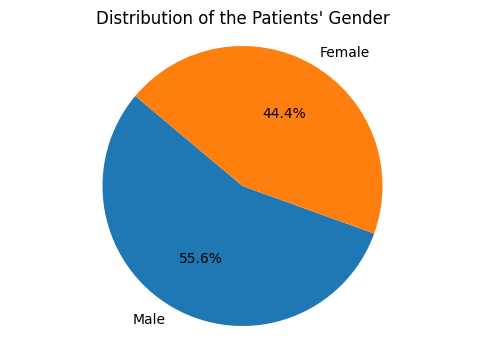

In [38]:
plt.figure(figsize=(6, 4))
plt.pie([male_percentage, female_percentage], labels=['Male', 'Female'], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of the Patients' Gender")
plt.axis('equal')
plt.show()

The pie chart shows that there is a slight majority of male patients among those who presented to the emergency department with this particular disease. This could be due to a number of factors, such as the biological differences between men and women that make them more susceptible to certain diseases, the different rates at which men and women seek medical attention for their symptoms, or the diagnostic criteria for the disease itself.

### **ETHNICITY**
A histogram was created to examine the distribution of patients across different ethnicities. The chart visualizes the eight most frequent ethnicities among the patients.

In [39]:
# Replacing variations of ethnicities with standardized values using regular expressions
individuals_data['ETHNICITY'] = individuals_data['ETHNICITY'].replace(to_replace=r'^ASIAN\D*', value='ASIAN', regex=True)\
    .replace(to_replace=r'^WHITE\D*', value='WHITE', regex=True)\
    .replace(to_replace=r'^HISPANIC\D*', value='HISPANIC/LATINO', regex=True)\
    .replace(to_replace=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', regex=True)\
    .replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', regex=True)

# Counting the occurrences of each ethnicity after standardization
individuals_data['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                        12717
UNKNOWN/NOT SPECIFIED                         1647
BLACK/AFRICAN AMERICAN                        1329
HISPANIC/LATINO                                493
OTHER                                          411
UNABLE TO OBTAIN                               378
ASIAN                                          371
PATIENT DECLINED TO ANSWER                     172
MULTI RACE ETHNICITY                            35
PORTUGUESE                                      15
MIDDLE EASTERN                                   9
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER        4
AMERICAN INDIAN/ALASKA NATIVE                    3
SOUTH AMERICAN                                   3
Name: count, dtype: Int64

In [40]:
# SQL query to select the ethnicity and count of patients for the top 8 ethnicities from the 'filtered_features' table
query_et = """
SELECT
  df.ETHNICITY,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.filtered_features AS df
GROUP BY
  df.ETHNICITY
ORDER BY
  num_patients DESC
LIMIT 8;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_et, use_cache=False)

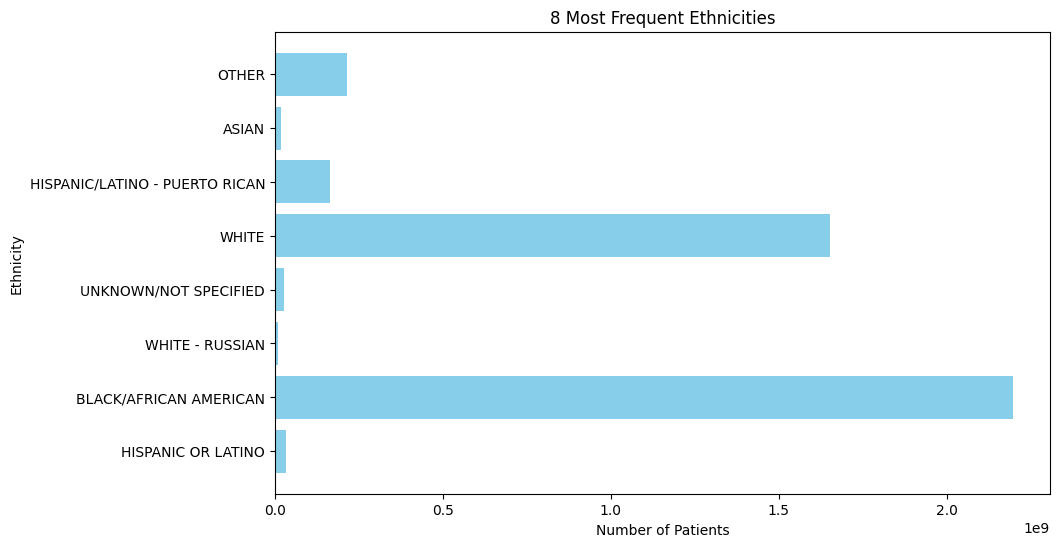

In [41]:
# Extracting ethnicity and number of patients from the 'results_df' dataframe
ethnicities = results_df['ETHNICITY']
num_patients = results_df['num_patients']

# Creating a horizontal bar plot to visualize the distribution of the top 8 ethnicities
plt.figure(figsize=(10, 6))
plt.barh(ethnicities, num_patients, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Ethnicity')
plt.title('8 Most Frequent Ethnicities')
plt.gca().invert_yaxis()  # Inverting y-axis to display the highest count at the top
plt.show()

The line graph shows that the racial and ethnic makeup of the patient population is diverse, with a majority of patients identifying as Black/African American . However, there is also a significant number of patients from other racial and ethnic groups, including White, Hispanic/Latino, Asian, and Other.

This distribution highlights the importance of considering ethnic backgrounds when addressing hypertension. Different ethnic groups may have varying risk factors and health behaviors that influence the prevalence of hypertension.

### **RELIGION**

In the analysis, a histogram was also created to examine the distribution of patients with hypertension across different religions.

In [43]:
# SQL query to select the religion and count of patients for the top 8 religions from the 'filtered_features' table
query_rel = """
SELECT
  df.RELIGION,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.filtered_features AS df
GROUP BY
  df.RELIGION
ORDER BY
  num_patients DESC
LIMIT 8;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_rel, use_cache=False)

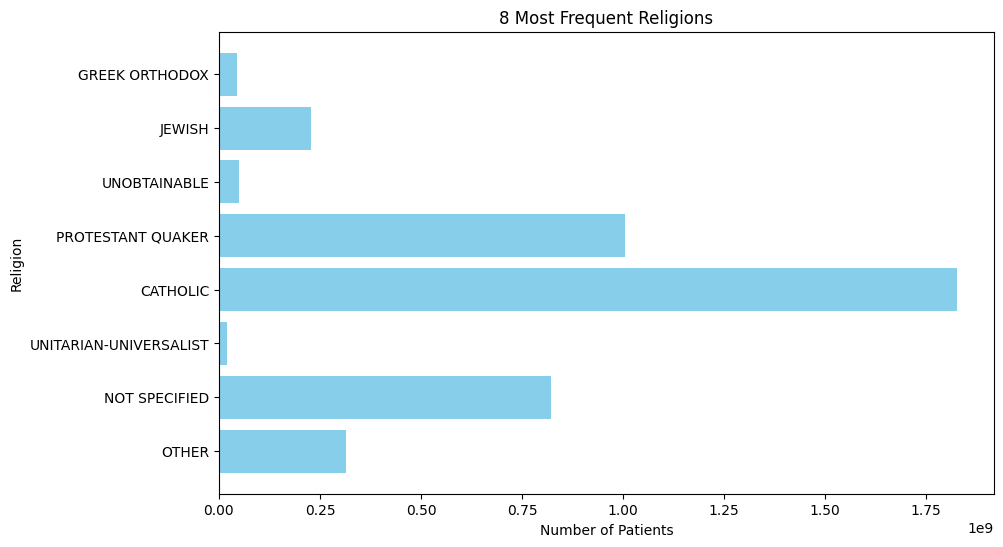

In [44]:
# Extracting religion and number of patients from the 'results_df' dataframe
rel = results_df['RELIGION']
num_patients = results_df['num_patients']

# Creating a horizontal bar plot to visualize the distribution of the top 8 religions
plt.figure(figsize=(10, 6))
plt.barh(rel, num_patients, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Religion')
plt.title('8 Most Frequent Religions')
plt.gca().invert_yaxis()  # Inverting y-axis to display the highest count at the top
plt.show()

The chart shows that the religious makeup of the patient population is diverse, with no single religion representing a majority of patients. The most common religion is Other, followed by Greek Orthodox, Protestant Quaker, Jewish, Catholic, Not Specified, Unobtainable, and Unitarian-Universalist.

Different religious groups may have varying lifestyles, dietary practices, and stress levels, which can impact the occurrence of hypertension.

### **LANGUAGE**


In the analysis, a histogram was also created to examine the distribution of patients with hypertension who speek diferent languages, therefore are from a specific country.

In [46]:
# SQL query to select the language and count of patients for the top 8 languages from the 'filtered_features' table
query_lan = """
SELECT
  df.LANGUAGE,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.filtered_features AS df
GROUP BY
  df.LANGUAGE
ORDER BY
  num_patients DESC
LIMIT 8;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_lan, use_cache=False)

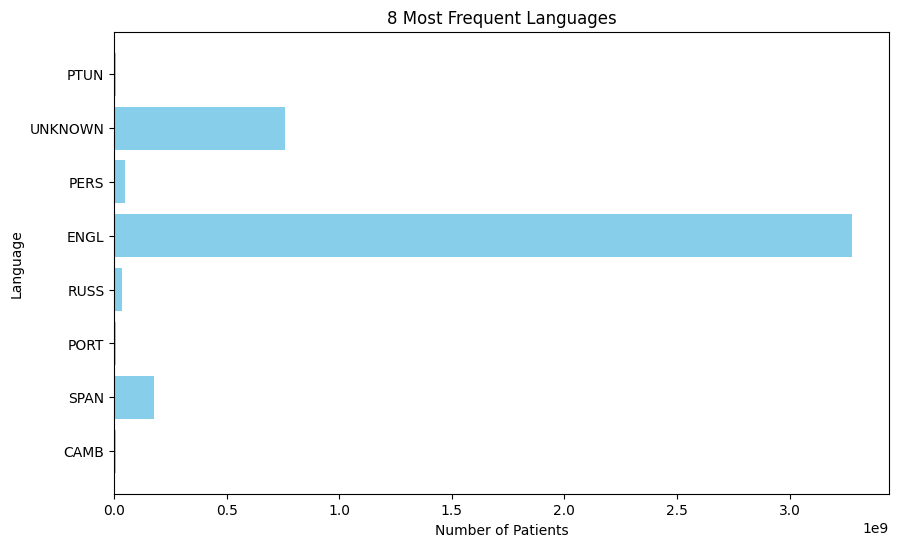

In [47]:
# Extracting language and number of patients from the 'results_df' dataframe
lan = results_df['LANGUAGE']
num_patients = results_df['num_patients']

# Creating a horizontal bar plot to visualize the distribution of the top 8 languages
plt.figure(figsize=(10, 6))
plt.barh(lan, num_patients, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Language')
plt.title('8 Most Frequent Languages')
plt.gca().invert_yaxis()  # Inverting y-axis to display the highest count at the top
plt.show()

The line graph shows that the linguistic makeup of the patient population is diverse, with a majority of patients speaking English. However, there is also a significant number of patients who speak other languages, including Mandarin Chinese, Spanish, Hindi, Arabic, Bengali, Portuguese, and Russian.

### **MARITAL STATUS**


In the analysis, a histogram was also created to examine the distribution of patients with hypertension who have different marital status.

In [49]:
# SQL query to select the marital status and count of patients for the top 8 marital statuses from the 'filtered_features' table
query_stat = """
SELECT
  df.MARITAL_STATUS,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.filtered_features AS df
GROUP BY
  df.MARITAL_STATUS
ORDER BY
  num_patients DESC
LIMIT 8;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_stat, use_cache=False)

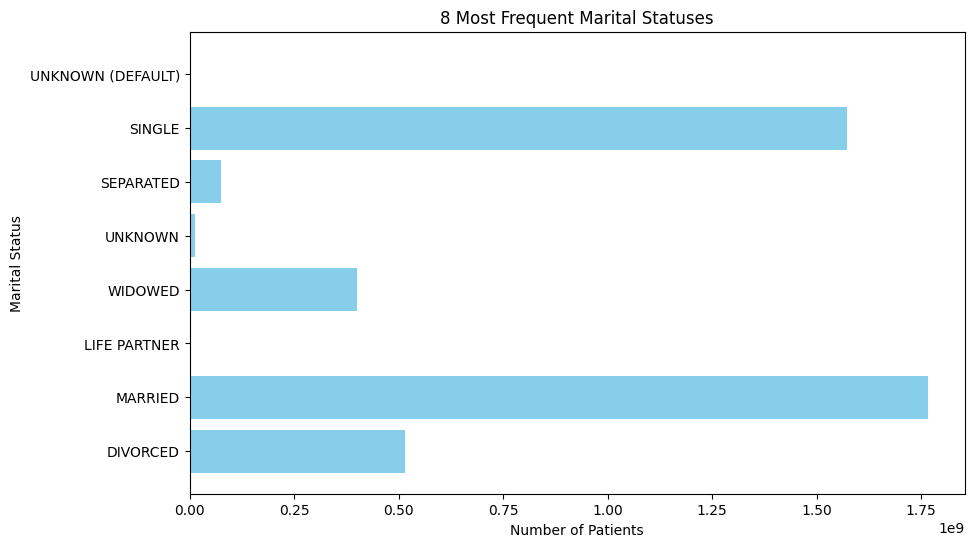

In [50]:
# Extracting marital status and number of patients from the 'results_df' dataframe
stat = results_df['MARITAL_STATUS']
num_patients = results_df['num_patients']

# Creating a horizontal bar plot to visualize the distribution of the top 8 marital statuses
plt.figure(figsize=(10, 6))
plt.barh(stat, num_patients, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Marital Status')
plt.title('8 Most Frequent Marital Statuses')
plt.gca().invert_yaxis()  # Inverting y-axis to display the highest count at the top
plt.show()

The bar graph shows that the marital makeup of the patient population is diverse, with a majority of patients being married. However, there is also a significant number of patients who are single, widowed, divorced, separated, or have an unknown marital status.

### **INSURANCE**

It was also created a histogram about the distribution of patients across different types of the insurance. The chart visualizes the most frequent insurance types among the patients.

In [51]:
# SQL query to select the insurance type and count of patients for the top 5 insurance types from the 'filtered_features' table
query_ins = """
SELECT
  df.INSURANCE,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.filtered_features AS df
GROUP BY
  df.INSURANCE
ORDER BY
  num_patients DESC
LIMIT 5;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_ins, use_cache=False)

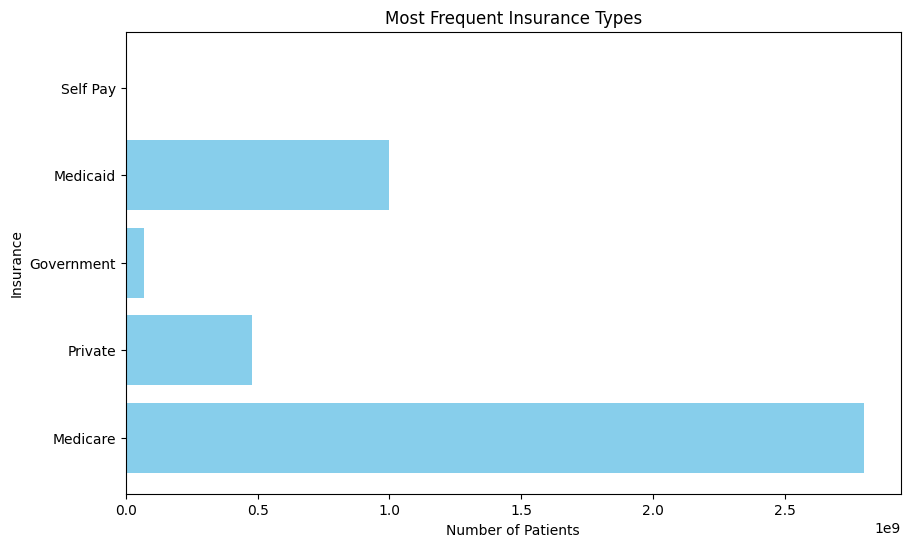

In [52]:
# Extracting insurance type and number of patients from the 'results_df' dataframe
ins = results_df['INSURANCE']
num_patients = results_df['num_patients']

# Creating a horizontal bar plot to visualize the distribution of the top 5 insurance types
plt.figure(figsize=(10, 6))
plt.barh(ins, num_patients, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Insurance')
plt.title('Most Frequent Insurance Types')
plt.gca().invert_yaxis()  # Inverting y-axis to display the highest count at the top
plt.show()

The bar chart shows that the insurance makeup of the patient population is diverse, with medical insurance being the most prevalent type of coverage. This suggests that a majority of patients have some form of health insurance, likely reflecting the importance of health coverage in accessing necessary medical care.

In [53]:
# Counting the occurrences of each insurance type in the 'INSURANCE' column and storing the result in 'insurance_count'
insurance_count = individuals_data['INSURANCE'].value_counts()

# Displaying the count of each insurance type
insurance_count

INSURANCE
Medicare      10781
Private        5236
Medicaid       1090
Government      365
Self Pay        115
Name: count, dtype: Int64

### **AGE**
We created a chart which visualizes the age groups of the patients.

In [125]:
# SQL query to calculate the age of patients based on admission time and birthdate,
# and then count the frequency of each age
age = """
  WITH age_calculation AS (
    SELECT
        SUBJECT_ID,
        GENDER,
        EXTRACT(YEAR FROM ADMITTIME) - EXTRACT(YEAR FROM DOB) AS AGE
    FROM
        cdl-pratica.Data.filtered_features
)

SELECT
    AGE,
    COUNT(*) AS frequency
FROM
    age_calculation
GROUP BY
    AGE
ORDER BY
    AGE
"""

# Executing the SQL query and storing the results in the 'df' dataframe
df = bpd.read_gbq(age, use_cache=False)

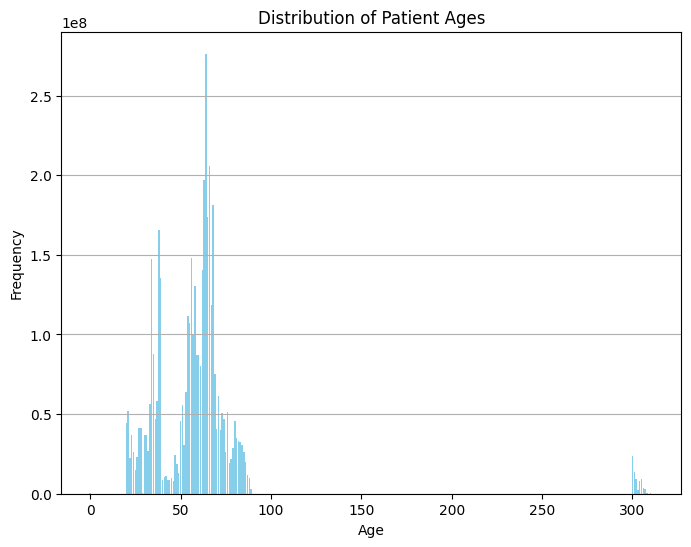

In [127]:
# Creating a bar plot to visualize the distribution of patient ages
plt.figure(figsize=(8, 6))
plt.bar(df['AGE'], df['frequency'], color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title("Distribution of Patient Ages")
plt.grid(axis='y')  # Adding gridlines along the y-axis
plt.show()

The bar chart reveals that the age distribution of the patient population is most frequent within the age ranges of approximately 20 to 30 and 60 to 85. This suggests that a significant proportion of patients fall within these age brackets, with peaks in both younger and older demographics. However, there are also some outliers towards the extremes of the age spectrum.

## **Exploring Hospital Admissions**

In [56]:
names_col = filtered_features.columns
print("Names of the Columns:", names_col)

Names of the Columns: Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME', 'ITEMID', 'LABEL',
       'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE', 'LOS', 'ICD9_CODE',
       'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


In [57]:
num_lines, num_col = filtered_features.shape
print(f"Number of lines: {num_lines}")
print(f"Number of columns: {num_col}")

Number of lines: 4348563127
Number of columns: 29


In [58]:
# Selecting relevant columns for entries data
relevant_col = ['HADM_ID', 'ICUSTAY_ID', 'DOB', 'GENDER','ADMITTIME', 'DISCHTIME', 'DEATHTIME','HOSPITAL_EXPIRE_FLAG','ADMISSION_TYPE','ERROR','LOS']

# Selecting only the relevant columns from 'unique_ids', sorting the result by 'HADM_ID', and storing it in 'entries_df'
entries_df = unique_ids[relevant_col].sort_values(by='HADM_ID')

# Displaying the first few rows of the entries data
entries_df.head()

,HADM_ID,ICUSTAY_ID,DOB,GENDER,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,ERROR,LOS
1315311,100007,217937,2071-06-04 00:00:00+00:00,F,2145-03-31 05:33:00+00:00,2145-04-07 12:40:00+00:00,<NA>,0,EMERGENCY,<NA>,4.0998
6984254,100009,253656,2101-07-30 00:00:00+00:00,M,2162-05-16 15:56:00+00:00,2162-05-21 13:37:00+00:00,<NA>,0,EMERGENCY,0,2.4908
3089855,100012,239289,2109-06-26 00:00:00+00:00,M,2177-03-12 11:48:00+00:00,2177-03-22 14:30:00+00:00,<NA>,0,EMERGENCY,0,3.5763
26552125,100024,201668,2099-05-27 00:00:00+00:00,M,2170-09-19 07:30:00+00:00,2170-09-25 15:30:00+00:00,<NA>,0,ELECTIVE,0,1.0799
100764,100031,210325,2059-06-08 00:00:00+00:00,F,2142-10-13 18:14:00+00:00,2142-10-19 14:45:00+00:00,<NA>,0,ELECTIVE,<NA>,6.8557


### **Types of Hospital Admissions**

In this section, a study about the type of hospital admission is conducted to access the distribution of that data.

In [61]:
# SQL query to select the admission type and count of patients from the 'entradas_df' table
query_AD = """
SELECT
  df.ADMISSION_TYPE,
  COUNT(*) AS num_patients
FROM
  cdl-pratica.Data.entradas_df AS df
GROUP BY
  df.ADMISSION_TYPE
ORDER BY
  num_patients DESC;
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_AD, use_cache=False)

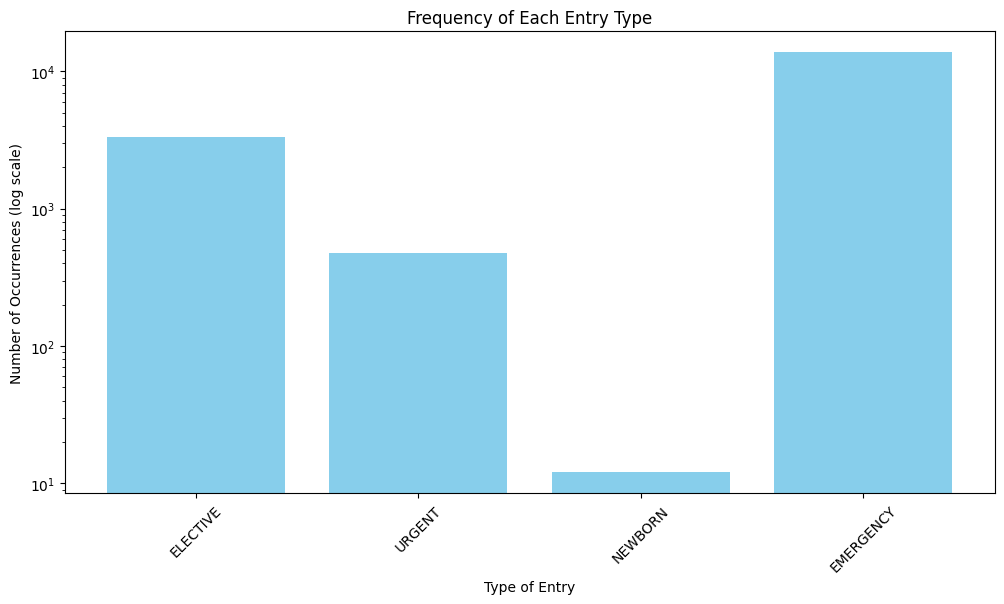

In [62]:
# Extracting admission type and number of patients from the 'results_df' dataframe
ad = results_df['ADMISSION_TYPE']
num_patients = results_df['num_patients']

# Creating a bar plot to visualize the frequency of each entry type
plt.figure(figsize=(12, 6))
plt.bar(ad, num_patients, color='skyblue')
plt.yscale('log')  # Using a logarithmic scale for the y-axis to better visualize the differences
plt.xlabel('Type of Entry')
plt.ylabel('Number of Occurrences (log scale)')
plt.title('Frequency of Each Entry Type')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

The histogram analysis reveals that emergency admissions are the most frequent, followed by elective, urgent, and newborn admissions, in descending order.

Understanding the distribution of hospital admissions by type is crucial for resource allocation, capacity planning, and prioritizing patient care.


### **Impact of Admission Type on Length of Hospital Stay**

This topic is a continuation of the one above, here it is accessed if the type of hospital admission has some sort of impact on the Length of Stay.

In [63]:
# Writing the 'entries_df' dataframe to the 'cdl-pratica.Data.entradas_df' table in Google BigQuery, replacing it if it already exists
entries_df.to_gbq('cdl-pratica.Data.entradas_df', if_exists='replace')

'cdl-pratica.Data.entradas_df'

In [64]:
# SQL query to select the admission type and average length of stay (LOS) from the 'entradas_df' table
query_entries = """
SELECT
  df.ADMISSION_TYPE,
  AVG(df.LOS) AS AVG_LOS
FROM
  cdl-pratica.Data.entradas_df AS df
GROUP BY
  df.ADMISSION_TYPE
"""

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_entries, use_cache=False)

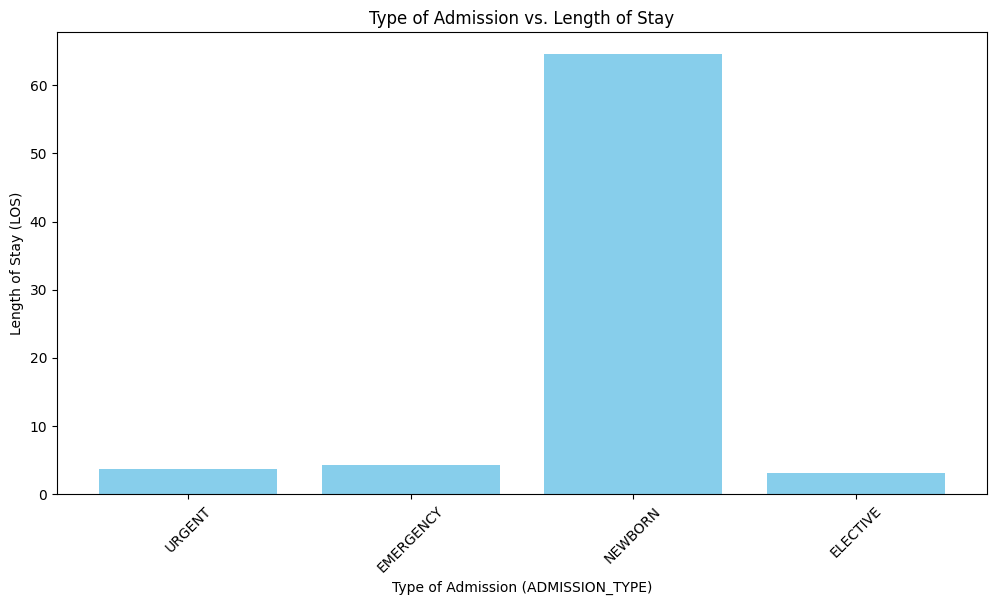

In [65]:
# Creating a bar plot to visualize the average length of stay (LOS) for each admission type
plt.figure(figsize=(12, 6))
plt.bar(results_df['ADMISSION_TYPE'], results_df['AVG_LOS'], color='skyblue')
plt.xlabel('Type of Admission (ADMISSION_TYPE)')
plt.ylabel('Length of Stay (LOS)')
plt.title('Type of Admission vs. Length of Stay')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

This analysis of the relationship between the type of hospital admission and length of stay indicates that newborn admissions have a longer duration, often exceeding 60 days. This likely reflects the comprehensive care and monitoring required for newborns, including preterm infants or those with complex medical needs.

In contrast, other admission types have a much shorter average length of stay, typically not exceeding 10 days.

### **Gender and Length of Stay Analysis**

In this section it is accessed if the gender has some sort of impact on the Length of Stay.

In [66]:
# SQL query to select the gender and average length of stay (LOS) from the 'entradas_df' table
query_entries2 = """
 SELECT
   df.GENDER,
   AVG(df.LOS) AS AVG_LOS
 FROM
   cdl-pratica.Data.entradas_df AS df
 GROUP BY
   df.GENDER
 """

# Executing the SQL query and storing the results in the 'results_df' dataframe
results_df = bpd.read_gbq(query_entries2, use_cache=False)

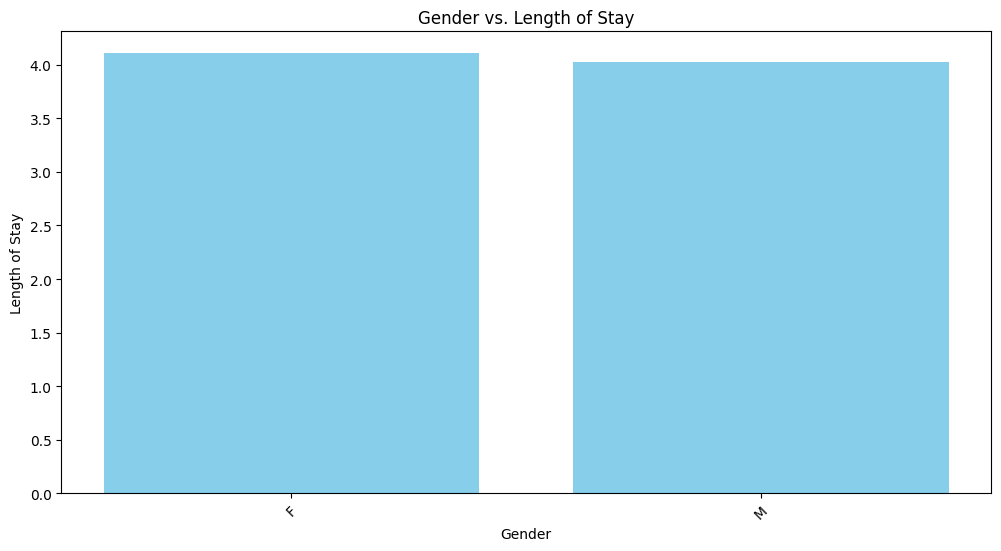

In [67]:
# Creating a bar plot to visualize the average length of stay (LOS) for each gender
plt.figure(figsize=(12, 6))
plt.bar(results_df['GENDER'], results_df['AVG_LOS'], color='skyblue')
plt.xlabel('Gender')
plt.ylabel('Length of Stay')
plt.title('Gender vs. Length of Stay')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

The analysis of gender and length of stay in the hospital aimed to determine if there was any significant difference in the duration of hospitalization between genders. However, the results indicate that the difference was minimal.

This suggests that there is no substantial gender-based disparity in hospital stay duration within the sample population. Both genders tend to have similar lengths of stay, indicating that hospitalization duration is not significantly influenced by gender factors in this context.

### **Analysis of Error Count and Length of Stay**

In this topic it is accessed if the hospital errors made have some sort of impact on the Length of Stay.

In [68]:
# Accessing the data type of the 'ERROR' column in the 'entries_df' DataFrame
entries_df['ERROR'].dtype

string[pyarrow]

In [69]:
# Counting the occurrences of each unique value in the 'ERROR' column and storing the result in 'error_count'
error_count = entries_df['ERROR'].value_counts()

# Displaying the count of occurrences for each unique value in the 'ERROR' column
error_count

ERROR
0    7899
1      36
Name: count, dtype: Int64

In [70]:
# SQL query to calculate the mean length of stay (LOS) for entries with error
sql = """
    SELECT
        AVG(df.LOS) AS los_mean_with_error
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.ERROR = '1'
"""

In [71]:
# Executing the SQL query and storing the results in the 'with_error_df' dataframe
with_error_df = bpd.read_gbq(sql, use_cache=False)

In [72]:
# SQL query to calculate the mean length of stay (LOS) for entries without error
without_error = """
    SELECT
        AVG(df.LOS) AS los_mean_without_error
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.ERROR = '0'
"""

In [73]:
# Executing the SQL query and storing the results in the 'without_error_df' dataframe
without_error_df = bpd.read_gbq(without_error, use_cache=False)

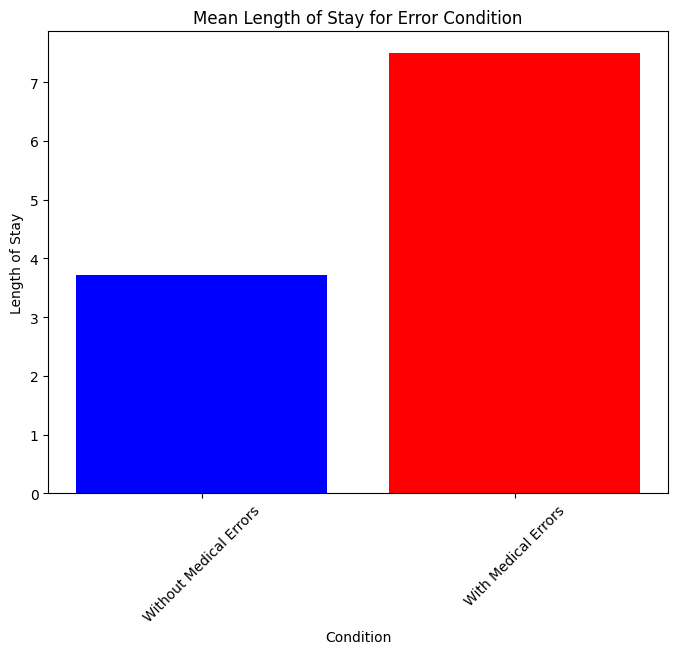

In [74]:
# Extracting the length of stay values for entries without and with medical errors
without_error = without_error_df.iloc[0, 0]
with_error = with_error_df.iloc[0, 0]

# Defining the names for the conditions
value_names = ['Without Medical Errors', 'With Medical Errors']

# Creating a list of heights for the bar plot
heights = [without_error, with_error]

# Defining colors for the bars
colors = ['blue', 'red']

# Creating a bar plot to visualize the mean length of stay for each condition
plt.figure(figsize=(8, 6))
plt.bar(value_names, heights, color=colors)
plt.xlabel('Condition')
plt.ylabel('Length of Stay')
plt.title("Mean Length of Stay for Error Condition")
plt.xticks(rotation=45)
plt.show()

The analysis regarding the number of medical errors and length of stay in the hospital reveals a significant correlation. Patients who experienced medical errors during their assessments had a notably longer average length of stay, exceeding 7 days. In contrast, patients who did not encounter any medical errors had a considerably shorter average length of stay, typically less than 4 days.

### **Number of Hospital Deaths**

In this section, a study about the number of deaths is conducted to access the distribution of that data.

In [75]:
# Accessing the data type of the 'HOSPITAL_EXPIRE_FLAG' column in the 'entries_df' DataFrame
entries_df['HOSPITAL_EXPIRE_FLAG'].dtype

Int64Dtype()

In [76]:
# SQL query to count the total number of deaths in the hospital (where HOSPITAL_EXPIRE_FLAG is 1)
hosp_deaths = """
    SELECT
         COUNT(*) AS total_deaths
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.HOSPITAL_EXPIRE_FLAG = 1
"""

In [77]:
# Executing the SQL query and storing the results in the 'hosp_deaths_df' dataframe
hosp_deaths_df = bpd.read_gbq(hosp_deaths, use_cache=False)

In [78]:
# SQL query to count the total number of hospital survivals (where HOSPITAL_EXPIRE_FLAG is 0)
surv_hosp = """
    SELECT
         COUNT(*) AS total_survivals
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.HOSPITAL_EXPIRE_FLAG = 0
"""

In [79]:
# Executing the SQL query and storing the results in the 'surv_hosp_df' dataframe
surv_hosp_df = bpd.read_gbq(surv_hosp, use_cache=False)

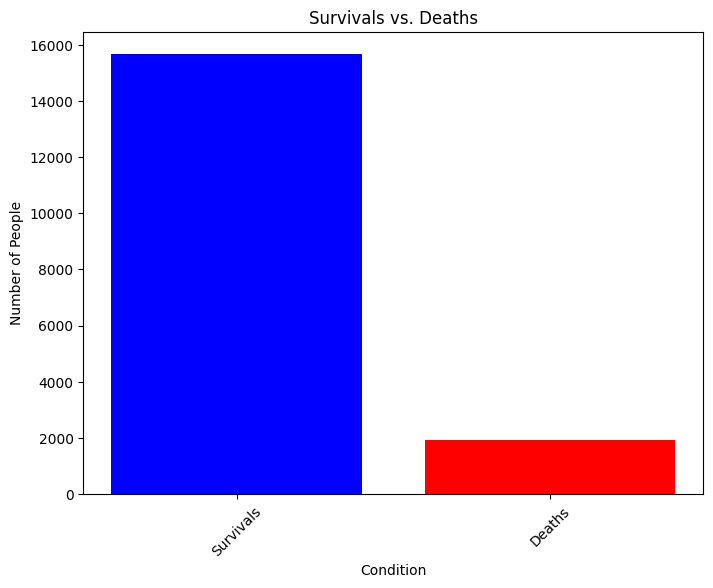

In [80]:
# Extracting the number of survivals and deaths
surv = surv_hosp_df.iloc[0, 0]
deaths = hosp_deaths_df.iloc[0, 0]

# Defining the names for the conditions
value_names = ['Survivals', 'Deaths']

# Creating a list of heights for the bar plot
heights = [surv, deaths]

# Defining colors for the bars
colors = ['blue', 'red']

# Creating a bar plot to visualize the number of survivals and deaths
plt.figure(figsize=(8, 6))
plt.bar(value_names, heights, color=colors)
plt.xlabel('Condition')
plt.ylabel('Number of People')
plt.title('Survivals vs. Deaths')
plt.xticks(rotation=45)
plt.show()

The bar graph shows that the survivals's rate is significantly higher than the deaths. Therefore, we can conclude that this disease has low death rate.

### **Hospital Deaths vs. Medical Errors**

This topic is a continuation of the ones above, here it is accessed if the hospital errors made have some sort of impact on the number of deaths.

In [81]:
# SQL query to count the total number of deaths in the hospital with error (where HOSPITAL_EXPIRE_FLAG is 1 and ERROR is 1)
deaths_with_error = """
    SELECT
         COUNT(*) AS total_deaths
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.HOSPITAL_EXPIRE_FLAG = 1 AND df.ERROR='1'
"""

In [82]:
# Executing the SQL query and storing the results in the 'with_error' dataframe
with_error = bpd.read_gbq(deaths_with_error, use_cache=False)

In [83]:
# SQL query to count the total number of deaths in the hospital without error (where HOSPITAL_EXPIRE_FLAG is 1 and ERROR is 0)
deaths_without_error = """
    SELECT
         COUNT(*) AS total_deaths
    FROM
        cdl-pratica.Data.entradas_df AS df
    WHERE
        df.HOSPITAL_EXPIRE_FLAG = 1 AND df.ERROR='0'
"""

In [84]:
# Executing the SQL query and storing the results in the 'without_error' dataframe
without_error = bpd.read_gbq(deaths_without_error, use_cache=False)

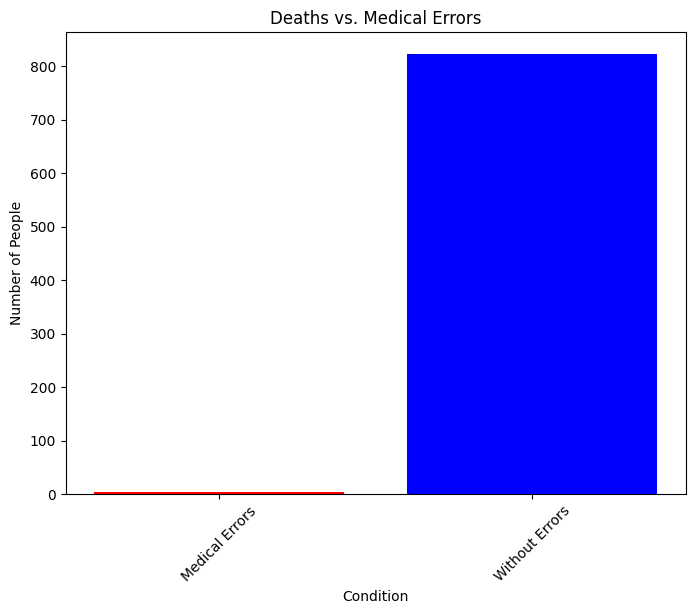

In [88]:
# Extracting the number of deaths with and without medical errors
with_ = with_error.iloc[0, 0]
without = without_error.iloc[0, 0]

# Defining the names for the conditions
value_names = ['Medical Errors', 'Without Errors']

# Creating a list of heights for the bar plot
heights = [with_, without]

# Defining colors for the bars
colors = ['red', 'blue']

# Creating a bar plot to visualize the number of deaths with and without medical errors
plt.figure(figsize=(8, 6))
plt.bar(value_names, heights, color=colors)
plt.xlabel('Condition')
plt.ylabel('Number of People')
plt.title('Deaths vs. Medical Errors')
plt.xticks(rotation=45)
plt.show()

The bar graph shows that the medical errors don't make an influence on the deaths.

### **Age and Length of Stay Analysis**

In this topic it is accessed if the age of the patients has some sort of impact on the Length of Stay.

In [86]:
# SQL query to calculate the average length of stay (LOS) for each age group
age_los = """
  WITH age_calculation AS (
    SELECT
        SUBJECT_ID,
        LOS,
        EXTRACT(YEAR FROM ADMITTIME) - EXTRACT(YEAR FROM DOB) AS AGE
    FROM
        cdl-pratica.Data.filtered_features
)

  SELECT
    AGE,
    AVG(LOS) AS AVG_LOS
  FROM
    age_calculation
  GROUP BY
    AGE
  ORDER BY
    AGE
"""

# Executing the SQL query and storing the results in the 'age' dataframe
age = bpd.read_gbq(age_los, use_cache=False)

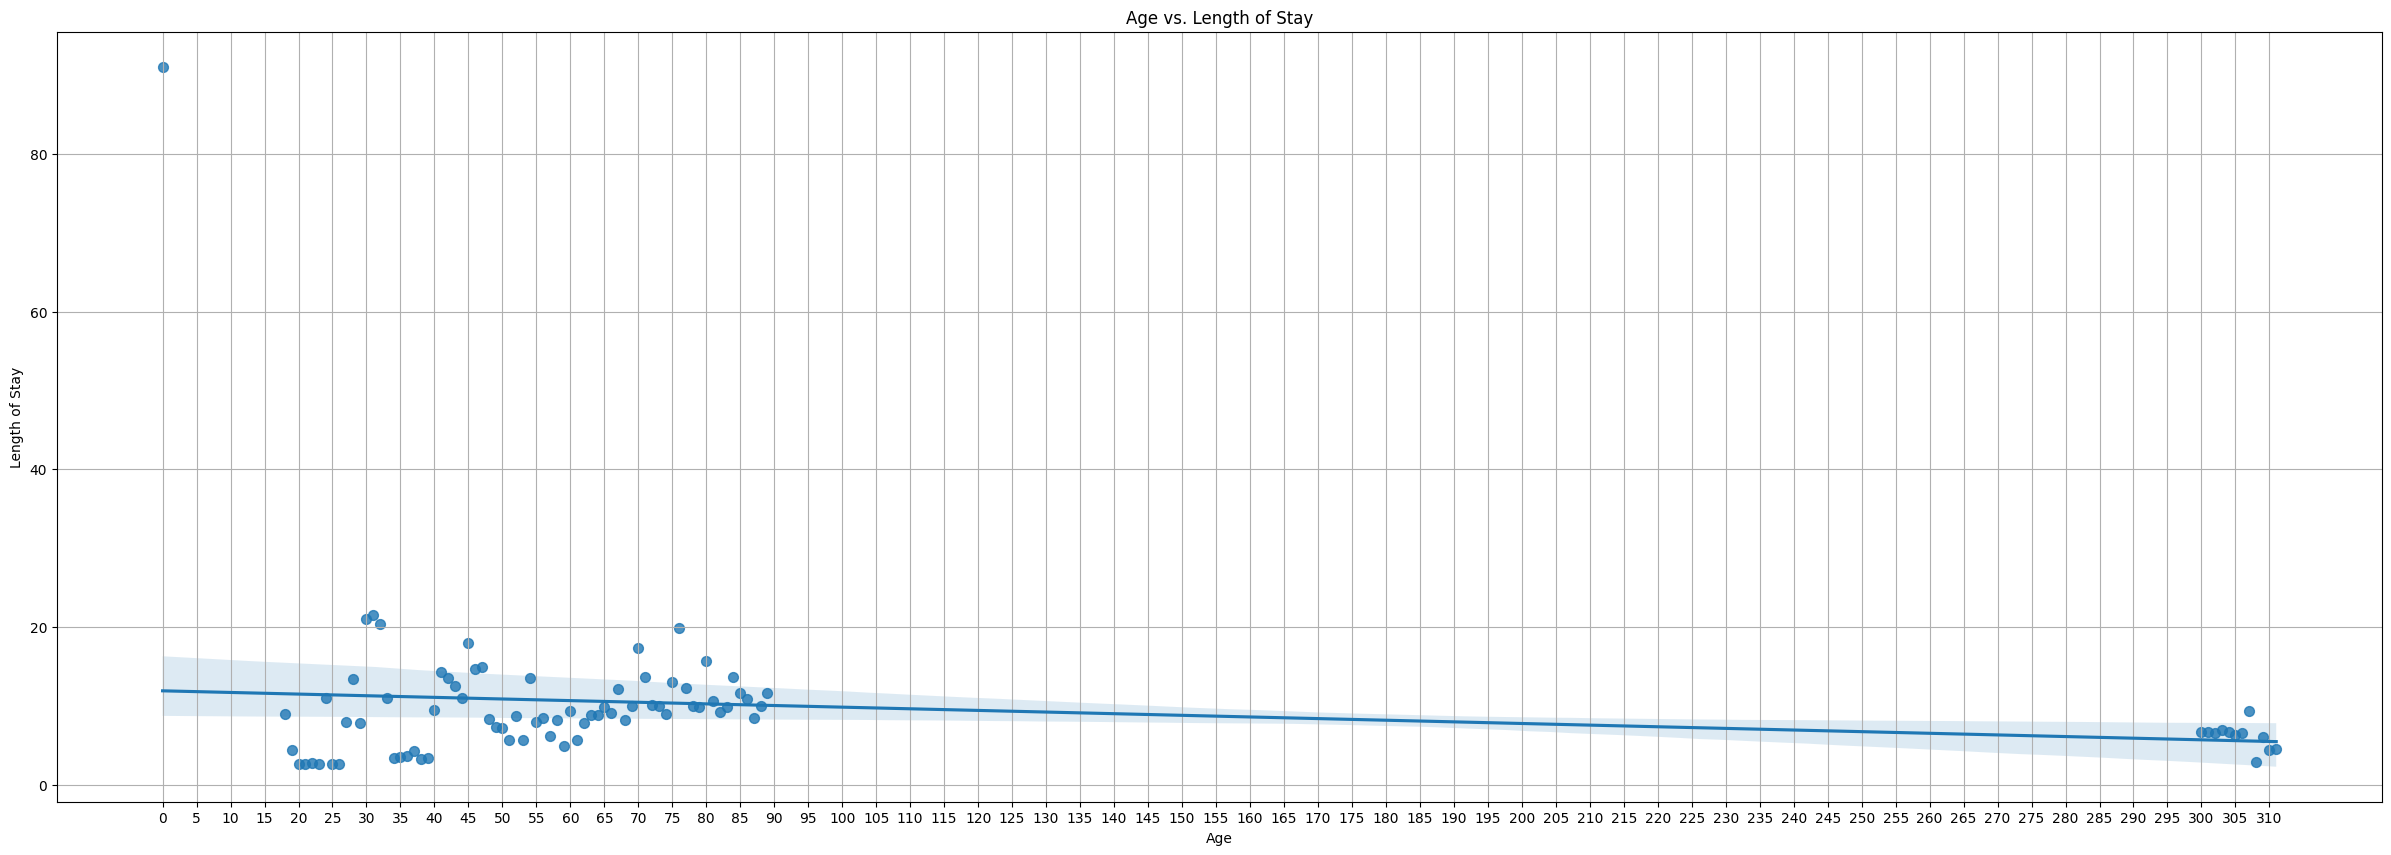

In [91]:
# Creating a scatter plot with a regression line to visualize the relationship between age and average length of stay
plt.figure(figsize=(30, 10))
sns.regplot(x='AGE', y='AVG_LOS', data=age, scatter_kws={'s': 50})
plt.xlabel('Age')
plt.ylabel('Length of Stay')
plt.title('Age vs. Length of Stay')
plt.xticks(range(0, max(age['AGE'])+1, 5))  # Setting x-axis ticks at intervals of 5 years
plt.grid(True)  # Adding gridlines
plt.show()

The scatter plot suggests that there is a weak positive correlation between age and length of stay in the ED. This means that there is a tendency for older patients to have longer ED stays. However, it is important to note that this is just a tendency, and there is a lot of variability in the data. There are many older patients who have short ED stays, and there are many younger patients who have long ED stays.

# **Using Other Tools(PySpark, Dask) - Only with the 500-line Dataset**
As outlined in the initial phase of our project, our primary objective was to conduct analyses using tools such as PySpark and Dask. However, due to the format of our final table in BigQuery, we encountered challenges in reading it for use with these tools. Not wanting to forgo the opportunity to explore and apply our knowledge of these big data methods, our only viable solution was to export the data as a CSV file through Google Sheets.

Unfortunately, we could only extract 500 lines from the billions of records available. Consequently, this dataset does not constitute a robust exploration of big data, and our analysis may not be as comprehensive or precise as with BigQuery. Nonetheless, this approach allows us to work with the tools we originally intended to use, albeit on a smaller scale.

It is important to note that while we are not currently utilizing these tools for large-scale data analysis, the structure and methodologies employed would be applicable in such scenarios. This exercise serves as a valuable opportunity to familiarize ourselves with the workflow and capabilities of these tools, which will be invaluable as we tackle larger datasets in the future.

## **Data Pre Processing**
Once again, we will address null values, outliers, and dimensionality but now using Apache Spark.

By leveraging the capabilities of Apache Spark, we can efficiently handle large volumes of data and implement robust preprocessing techniques to enhance the integrity and usability of our dataset.

In [140]:
# Defining the path to the raw features CSV file stored in Google Cloud Storage
path = "gs://up202107955/Trabalho/Data/raw_features.csv"

In [141]:
df = pd.read_csv(path)
df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
0,15472,169182,NaN,2/8/2114 0:00:00,12/5/2178 0:59:00,12/21/2178 16:12:00,NaN,0,EMERGENCY,M,...,Heart Rhythm,Atrial Fib,NaN,NaN,NaN,carevue,NaN,4019,Hypertension NOS,14
1,3371,106552,NaN,6/10/2127 0:00:00,10/3/2185 7:15:00,10/10/2185 15:30:00,NaN,0,ELECTIVE,M,...,Arterial PaCO2,40,40.0,NaN,NaN,carevue,NaN,4019,Hypertension NOS,4
2,15472,169182,NaN,2/8/2114 0:00:00,1/18/2178 13:00:00,1/23/2178 17:05:00,NaN,0,EMERGENCY,M,...,Urine [Color],Yellow,NaN,NaN,NaN,carevue,NaN,4019,Hypertension NOS,8
3,6132,129355,NaN,12/12/2070 0:00:00,8/24/2133 16:53:00,9/18/2133 14:35:00,NaN,0,EMERGENCY,M,...,Urine [Color],Amber,NaN,NaN,NaN,carevue,NaN,4019,Hypertension NOS,13
4,1006,147743,NaN,8/27/2085 0:00:00,8/20/2159 22:15:00,8/29/2159 14:43:00,8/29/2159 14:43:00,1,EMERGENCY,M,...,Arterial PaO2,122,122.0,NaN,NaN,carevue,NaN,4019,Hypertension NOS,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,24099,195498,205357.0,1/13/2125 0:00:00,3/10/2198 17:48:00,3/12/2198 14:39:00,NaN,0,EMERGENCY,M,...,INR (2-4 ref. range),1.1,1.1,NaN,NaN,carevue,13.7972,4019,Hypertension NOS,8
496,24099,195498,205357.0,1/13/2125 0:00:00,9/1/2194 23:03:00,9/4/2194 10:20:00,NaN,0,EMERGENCY,M,...,Support Systems,Spouse,NaN,NaN,NaN,carevue,13.7972,4019,Hypertension NOS,9
497,24099,195498,205357.0,1/13/2125 0:00:00,9/1/2194 23:03:00,9/4/2194 10:20:00,NaN,0,EMERGENCY,M,...,Back Care,Done,NaN,NaN,NaN,carevue,13.7972,4019,Hypertension NOS,9
498,24099,195498,205357.0,1/13/2125 0:00:00,3/10/2198 17:48:00,3/12/2198 14:39:00,NaN,0,EMERGENCY,M,...,GI Prophylaxis [Drug #1],NaN,NaN,NaN,NaN,carevue,13.7972,4019,Hypertension NOS,10


In [142]:
# Creating a SparkSession with the specified application name "Data Pre Processing"
spark = SparkSession.builder \
    .appName("Data Pre Processing") \
    .getOrCreate()

In [143]:
# Creating a Spark DataFrame from the pandas DataFrame 'df'
spark_df = spark.createDataFrame(df)

In [144]:
num_rows = spark_df.count()
num_cols = len(spark_df.columns)
print("DataFrames's Shape:", (num_rows, num_cols))

DataFrames's Shape: (500, 29)


### **Null Values**

In [145]:
# Calculate null and NaN counts for each column
null_counts = spark_df.select([
    coalesce(count(when(col(c).isNull() | isnan(col(c)), c)), lit(0)).alias(c)
    for c in spark_df.columns
])

# Show the result
null_counts.show()


+----------+-------+----------+---+---------+---------+---------+--------------------+--------------+------+---------+--------+--------+--------------+---------+---------------+----------+-----------+------+-----+-----+--------+-------+-----+--------+---+---------+-----------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DOB|ADMITTIME|DISCHTIME|DEATHTIME|HOSPITAL_EXPIRE_FLAG|ADMISSION_TYPE|GENDER|ETHNICITY|RELIGION|LANGUAGE|MARITAL_STATUS|INSURANCE|CALLOUT_OUTCOME|CREATETIME|OUTCOMETIME|ITEMID|LABEL|VALUE|VALUENUM|WARNING|ERROR|DBSOURCE|LOS|ICD9_CODE|SHORT_TITLE|SEQ_NUM|
+----------+-------+----------+---+---------+---------+---------+--------------------+--------------+------+---------+--------+--------+--------------+---------+---------------+----------+-----------+------+-----+-----+--------+-------+-----+--------+---+---------+-----------+-------+
|       0.0|    0.0|       0.0|0.0|      0.0|      0.0|      0.0|                 0.0|           0.0|   0.0|      0.0|     0.0|     0.0|      

##### **Eliminate the lines which have null values in the following columns: 'ICUSTAY_ID', 'LOS'**

In [146]:
# Dropping rows with missing values in the 'ICUSTAY_ID' and 'LOS' columns in the Spark DataFrame
spark_df = spark_df.dropna(subset=['ICUSTAY_ID', 'LOS'])

In [147]:
num_rows = spark_df.count()
num_cols = len(spark_df.columns)
print("DataFrame's Shape:", (num_rows, num_cols))

DataFrame's Shape: (492, 29)


##### **Eliminate the columns 'WARNING', 'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME' once they only/mostly have null values**

In [148]:
# Dropping the specified columns from the Spark DataFrame
columns_to_drop = ['WARNING', 'CALLOUT_OUTCOME', 'CREATETIME', 'OUTCOMETIME', 'DEATHTIME_UNIX']
spark_df = spark_df.drop(*columns_to_drop)

In [149]:
num_rows = spark_df.count()
num_cols = len(spark_df.columns)
print("DataFrame's Shape:", (num_rows, num_cols))

DataFrame's Shape: (492, 25)


##### **Calculate the mean of the rest of the null values on numeric columns and replace by "unknown" on the non numeric columns**

In [150]:
# Convert the NaN values of the DEATHTIME column to None so it can be recognized as a null value beacuse the type of the column is String
spark_df = spark_df.withColumn('DEATHTIME', when(col('DEATHTIME') == 'NaN', None).otherwise(col('DEATHTIME')))

In [151]:
# Filling missing values in the 'DEATHTIME' column with the string 'unknown' in the Spark DataFrame
spark_df = spark_df.na.fill({'DEATHTIME': 'unknown'})

In [152]:
# Replacing 'NaN' values in the 'LANGUAGE', 'MARITAL_STATUS', and 'RELIGION' columns with None in the Spark DataFrame
spark_df = spark_df.withColumn('LANGUAGE', when(col('LANGUAGE') == 'NaN', None).otherwise(col('LANGUAGE')))
spark_df = spark_df.withColumn('MARITAL_STATUS', when(col('MARITAL_STATUS') == 'NaN', None).otherwise(col('MARITAL_STATUS')))
spark_df = spark_df.withColumn('RELIGION', when(col('RELIGION') == 'NaN', None).otherwise(col('RELIGION')))

In [153]:
error_column_type = spark_df.schema['ERROR'].dataType
print("Columns Error type of data:", error_column_type)


Columns Error type of data: DoubleType()


In [154]:
# Replacing null values in the 'ERROR' column with the string 'unknown' in the Spark DataFrame
spark_df = spark_df.withColumn('ERROR', when(spark_df['ERROR'].isNull(), 'unknown').otherwise(spark_df['ERROR']))

In [155]:
# Default values for the columns
default_values = {'LANGUAGE': 'unknown', 'MARITAL_STATUS': 'unknown', 'RELIGION': 'unknown', 'ERROR': 'unknown'}

#Fill missing values in the specified columns
spark_df = spark_df.na.fill(default_values)

In [156]:
# Replacing null or NaN values in the 'VALUE' column with the string 'unknown' in the Spark DataFrame
spark_df = spark_df.withColumn('VALUE', when(col('VALUE').isNull() | isnan(col('VALUE')), 'unknown').otherwise(col('VALUE')))

# Extracting RDD from the Spark DataFrame
rdd = spark_df.rdd

# Map Phase: Filtering out rows with non-null and non-NaN 'VALUENUM', then mapping them to (VALUENUM, 1) pairs
valuenum_rdd = rdd.filter(lambda row: row['VALUENUM'] is not None and not math.isnan(row['VALUENUM'])) \
                  .map(lambda row: (row['VALUENUM'], 1))

# Reduce Phase: Summing up the 'VALUENUM' values and the counts
valuenum_sum_count = valuenum_rdd.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculating the mean of 'VALUENUM'
valuenum_mean = valuenum_sum_count[0] / valuenum_sum_count[1]
print("Mean of VALUENUM:", valuenum_mean)

# Filling null or NaN values in the 'VALUENUM' column with the calculated mean in the Spark DataFrame
spark_df = spark_df.withColumn('VALUENUM',
                               when(col('VALUENUM').isNull() | isnan(col('VALUENUM')), valuenum_mean)
                               .otherwise(col('VALUENUM')))

Mean of VALUENUM: 66.35121097903026


In [157]:
# Calculate null and NaN counts for each column
null_counts = spark_df.select([
    coalesce(count(when(col(c).isNull() | isnan(col(c)), c)), lit(0)).alias(c)
    for c in spark_df.columns
])

# Show the result
null_counts.show()


+----------+-------+----------+---+---------+---------+---------+--------------------+--------------+------+---------+--------+--------+--------------+---------+------+-----+-----+--------+-----+--------+---+---------+-----------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DOB|ADMITTIME|DISCHTIME|DEATHTIME|HOSPITAL_EXPIRE_FLAG|ADMISSION_TYPE|GENDER|ETHNICITY|RELIGION|LANGUAGE|MARITAL_STATUS|INSURANCE|ITEMID|LABEL|VALUE|VALUENUM|ERROR|DBSOURCE|LOS|ICD9_CODE|SHORT_TITLE|SEQ_NUM|
+----------+-------+----------+---+---------+---------+---------+--------------------+--------------+------+---------+--------+--------+--------------+---------+------+-----+-----+--------+-----+--------+---+---------+-----------+-------+
|       0.0|    0.0|       0.0|0.0|      0.0|      0.0|      0.0|                 0.0|           0.0|   0.0|      0.0|     0.0|     0.0|           0.0|      0.0|   0.0|  0.0|  0.0|     0.0|  0.0|     0.0|0.0|      0.0|        0.0|    0.0|
+----------+-------+----------+---+---------

### **Outliers**

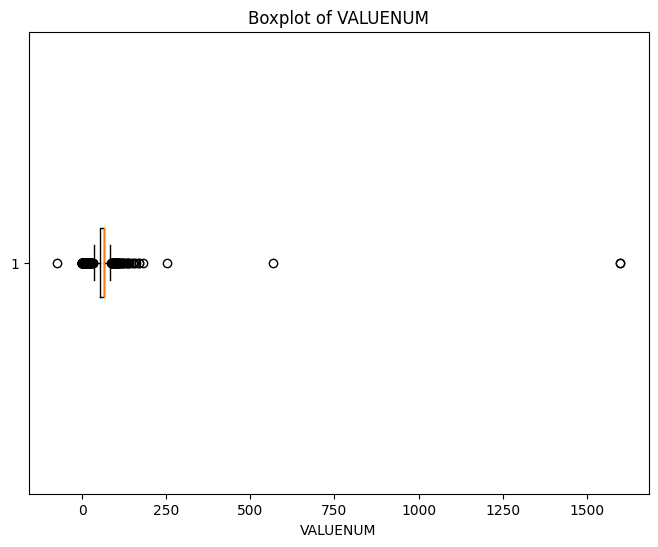

In [158]:
# Selecting the 'VALUENUM' column from the Spark DataFrame and converting it to a pandas DataFrame
data = spark_df.select('VALUENUM').toPandas()

# Creating a boxplot of the 'VALUENUM' column
plt.figure(figsize=(8, 6))
plt.boxplot(data['VALUENUM'], vert=False)
plt.title('Boxplot of VALUENUM')
plt.xlabel('VALUENUM')
plt.show()

In [159]:
# Defining a function to remove outliers from a Spark DataFrame based on a specified column and range
def remove_outliers(df, column, lower_limit, upper_limit):
    df = df.filter((col(column) >= lower_limit) & (col(column) <= upper_limit))
    return df

# Specifying the lower and upper limits for the 'VALUENUM' column
lower_limit = -100
upper_limit = 200

# Removing outliers from the 'VALUENUM' column in the Spark DataFrame
spark_df = remove_outliers(spark_df, 'VALUENUM', lower_limit, upper_limit)

In [160]:
num_rows = spark_df.count()
num_cols = len(spark_df.columns)
print("DataFrame's Shape:", (num_rows, num_cols))

DataFrame's Shape: (488, 25)


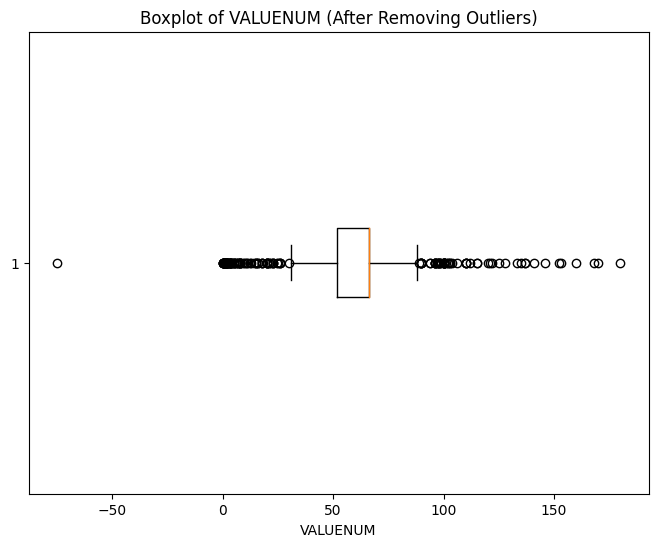

In [161]:
# Selecting the 'VALUENUM' column from the Spark DataFrame and converting it to a pandas DataFrame
data_cleaned_pandas = spark_df.select('VALUENUM').toPandas()

# Creating a boxplot of the 'VALUENUM' column after removing outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data_cleaned_pandas['VALUENUM'], vert=False)
plt.title('Boxplot of VALUENUM (After Removing Outliers)')
plt.xlabel('VALUENUM')
plt.show()

### **Reduction of dimensionality**

In [162]:
# Grouping the Spark DataFrame by 'SUBJECT_ID'
grouped_df = spark_df.groupBy('SUBJECT_ID')

# Aggregating statistics for 'VALUENUM' within each group
agg_df = grouped_df.agg(
    F.min('VALUENUM').alias('min_VALUENUM'),
    F.max('VALUENUM').alias('max_VALUENUM'),
    F.mean('VALUENUM').alias('avg_VALUENUM')
)

# Finding the top 10 most frequent items based on 'ITEMID'
top_most_frequent_items = spark_df.groupBy('ITEMID').count().orderBy(F.desc('count')).limit(10)

# Finding the top 10 least frequent items based on 'ITEMID'
top_least_frequent_items = spark_df.groupBy('ITEMID').count().orderBy('count').limit(10)

# Displaying the aggregated statistics, top most frequent items, and top least frequent items
agg_df.show()
top_most_frequent_items.show()
top_least_frequent_items.show()

+----------+-----------------+-----------------+------------------+
|SUBJECT_ID|     min_VALUENUM|     max_VALUENUM|      avg_VALUENUM|
+----------+-----------------+-----------------+------------------+
|     32092|             30.0|66.35121097903026| 48.17560548951513|
|     17205|66.35121097903026|66.35121097903026| 66.35121097903026|
|     17949|              1.0|             96.0| 60.09389140434494|
|      5641|66.35121097903026|66.35121097903026| 66.35121097903026|
|      9374|66.35121097903026|            121.0|  80.0134082342727|
|     23761|              1.0|              1.0|               1.0|
|      4096|            120.0|            120.0|             120.0|
|     22119|              0.5|66.35121097903026|47.650807319353504|
|      3436|66.35121097903026|66.35121097903026| 66.35121097903026|
|     25487|              0.5|            137.0| 75.83333333333333|
|     13789|              4.0|            110.0| 60.11707032634342|
|     17640|              2.5|              2.5|

In [163]:
# Renaming the 'SUBJECT_ID' column in agg_df to avoid conflicts
agg_df = agg_df.withColumnRenamed("SUBJECT_ID", "SUBJECT_ID_agg")

# Joining the original Spark DataFrame with the aggregated DataFrame based on 'SUBJECT_ID'
spark_df = spark_df.join(agg_df, spark_df.SUBJECT_ID == agg_df.SUBJECT_ID_agg, "left_outer")

# Selecting only the 'ITEMID' column from top_most_frequent_items and top_least_frequent_items
top_most_frequent_items = top_most_frequent_items.select('ITEMID')
top_least_frequent_items = top_least_frequent_items.select('ITEMID')

# Dropping the 'SUBJECT_ID_agg' column from the joined Spark DataFrame
columns_to_drop = ['SUBJECT_ID_agg']
spark_df = spark_df.drop(*columns_to_drop)

# Dropping the 'VALUENUM' column from the joined Spark DataFrame
spark_df = spark_df.drop('VALUENUM')

# Displaying the joined Spark DataFrame, top most frequent items, and top least frequent items
spark_df.show()
top_most_frequent_items.show()
top_least_frequent_items.show()

+----------+-------+----------+------------------+-------------------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+----------+------+--------------------+----------------+-----+----------+-------+---------+----------------+-------+-----------------+-----------------+-----------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|               DOB|          ADMITTIME|          DISCHTIME|          DEATHTIME|HOSPITAL_EXPIRE_FLAG|ADMISSION_TYPE|GENDER|           ETHNICITY|            RELIGION|LANGUAGE|MARITAL_STATUS| INSURANCE|ITEMID|               LABEL|           VALUE|ERROR|  DBSOURCE|    LOS|ICD9_CODE|     SHORT_TITLE|SEQ_NUM|     min_VALUENUM|     max_VALUENUM|     avg_VALUENUM|
+----------+-------+----------+------------------+-------------------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+-

### **Calculate the age of the patients**

In [164]:
def calculate_age_on_admit(dob_str, admit_str):
    # Converting date strings to datetime objects and extracting the date part
    birth_date = datetime.strptime(dob_str, "%m/%d/%Y %H:%M:%S").date()
    admit_date = datetime.strptime(admit_str, "%m/%d/%Y %H:%M:%S").date()

    # Calculating age based on birth date and admission date
    age = admit_date.year - birth_date.year - ((admit_date.month, admit_date.day) < (birth_date.month, birth_date.day))

    return age

In [165]:
# Defining a User Defined Function (UDF) for calculating age on admission
age_udf = udf(calculate_age_on_admit, IntegerType())

In [166]:
# Applying the age_udf to calculate age on admission and creating a new column 'AGE' in the Spark DataFrame
spark_df = spark_df.withColumn("AGE", age_udf(col("DOB"), col("ADMITTIME")))

##### **Eliminate the Date Of Birth column**

In [167]:
# Dropping the columns 'DOB' and 'ADMITTIME' from the Spark DataFrame
columns_to_drop = ['DOB', 'ADMITTIME']
spark_df = spark_df.drop(*columns_to_drop)

In [168]:
spark_df.show()

+----------+-------+----------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+----------+------+--------------------+----------------+-----+----------+-------+---------+----------------+-------+-----------------+-----------------+-----------------+---+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          DISCHTIME|          DEATHTIME|HOSPITAL_EXPIRE_FLAG|ADMISSION_TYPE|GENDER|           ETHNICITY|            RELIGION|LANGUAGE|MARITAL_STATUS| INSURANCE|ITEMID|               LABEL|           VALUE|ERROR|  DBSOURCE|    LOS|ICD9_CODE|     SHORT_TITLE|SEQ_NUM|     min_VALUENUM|     max_VALUENUM|     avg_VALUENUM|AGE|
+----------+-------+----------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+----------+------+--------------------+----------------+-----+----------+-------+---------+----------------+--

### **Put the 'LOS' column as the last column of the dataset**

In [169]:
# Selecting all columns except 'LOS', then appending 'LOS' to the list of columns
columns = [col_name for col_name in spark_df.columns if col_name != 'LOS']
columns.append('LOS')

# Selecting the DataFrame with the new column order
spark_df = spark_df.select(columns)

# Displaying the DataFrame
spark_df.show()

+----------+-------+----------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+----------+------+--------------------+----------------+-----+----------+---------+----------------+-------+-----------------+-----------------+-----------------+---+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          DISCHTIME|          DEATHTIME|HOSPITAL_EXPIRE_FLAG|ADMISSION_TYPE|GENDER|           ETHNICITY|            RELIGION|LANGUAGE|MARITAL_STATUS| INSURANCE|ITEMID|               LABEL|           VALUE|ERROR|  DBSOURCE|ICD9_CODE|     SHORT_TITLE|SEQ_NUM|     min_VALUENUM|     max_VALUENUM|     avg_VALUENUM|AGE|    LOS|
+----------+-------+----------+-------------------+-------------------+--------------------+--------------+------+--------------------+--------------------+--------+--------------+----------+------+--------------------+----------------+-----+----------+---------+----------------+-------+--

### **Ethnicity Categorization**

In [170]:
# Replacing specific patterns in the 'ETHNICITY' column using regular expressions
spark_df = spark_df.withColumn('ETHNICITY', regexp_replace('ETHNICITY', r'^ASIAN\D*', 'ASIAN'))
spark_df = spark_df.withColumn('ETHNICITY', regexp_replace('ETHNICITY', r'^WHITE\D*', 'WHITE'))
spark_df = spark_df.withColumn('ETHNICITY', regexp_replace('ETHNICITY', r'^HISPANIC\D*', 'HISPANIC/LATINO'))
spark_df = spark_df.withColumn('ETHNICITY', regexp_replace('ETHNICITY', r'^BLACK\D*', 'BLACK/AFRICAN AMERICAN'))
spark_df = spark_df.withColumn('ETHNICITY', regexp_replace('ETHNICITY', 'UNABLE TO OBTAIN|OTHER|PATIENT DECLINED TO ANSWER|UNKNOWN/NOT SPECIFIED', 'OTHER/UNKNOWN'))

# Grouping by 'ETHNICITY' and counting occurrences, then ordering by count in descending order
ethnicity_counts = spark_df.groupBy('ETHNICITY').count().orderBy('count', ascending=False)
ethnicity_counts.show()

+--------------------+-----+
|           ETHNICITY|count|
+--------------------+-----+
|               WHITE|  344|
|       OTHER/UNKNOWN|   53|
|BLACK/AFRICAN AME...|   45|
|               ASIAN|   31|
|     HISPANIC/LATINO|   13|
|MULTI RACE ETHNICITY|    2|
+--------------------+-----+



## **DataSet Visualization**
In this section, we will perform the same analysis as conducted in BigQuery but using Dask. The Spark DataFrame was converted to a Pandas DataFrame, and then the Pandas DataFrame was further converted to a Dask DataFrame with 2 partitions.

It's important to note that all visualizations from this point onwards will yield different results compared to the queries. Due to the reduced quantity of data available, the results are not as comprehensive or precise.

In [171]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()

# Converting Pandas DataFrame to Dask DataFrame with 2 partitions
dask_df = dd.from_pandas(pandas_df, npartitions=2)

In [172]:
dask_df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,ETHNICITY,RELIGION,LANGUAGE,MARITAL_STATUS,INSURANCE,ITEMID,LABEL,VALUE,ERROR,DBSOURCE,ICD9_CODE,SHORT_TITLE,SEQ_NUM,min_VALUENUM,max_VALUENUM,avg_VALUENUM,AGE,LOS
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,string,string,int64,string,string,string,string,string,string,string,int64,string,string,string,string,int64,string,int64,float64,float64,float64,int32,float64
244,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## **Exploring Patients**

### **GENDER**
In this small sample, we observe that men have a higher tendency for the disease compared to women. Specifically, men account for 60.2% while women account for 39.8% of the cases.

It's important to note that this difference is more pronounced compared to the results obtained from BigQuery. This discrepancy is attributed to the significantly smaller size of the dataset being analyzed.

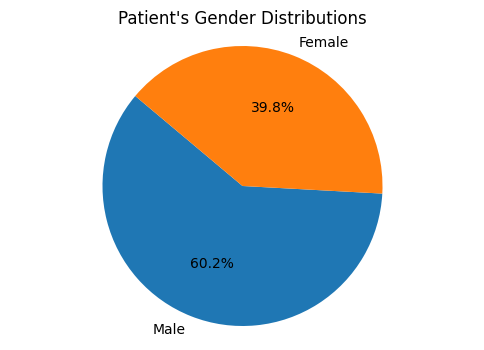

In [173]:
# Computing value counts of gender using Dask DataFrame and then computing to get the result
gender_count = dask_df['GENDER'].value_counts().compute()

# Calculating total number of patients
total_patients = gender_count.sum()

# Calculating percentages of males and females
male_percentage = (gender_count['M'] / total_patients) * 100
female_percentage = (gender_count['F'] / total_patients) * 100

# Plotting the pie chart for gender distribution
plt.figure(figsize=(6, 4))
plt.pie([male_percentage, female_percentage], labels=['Male', 'Female'], autopct='%1.1f%%', startangle=140)
plt.title("Patient's Gender Distributions")
plt.axis('equal')
plt.show()

### **ETHNICITY**

In this dataset, we observe differences in ethnicity distribution, with "White" being the most frequent, followed by "Black/African American" and "Asian". This pattern mirrors some of the trends seen in larger datasets, although the proportions may vary due to the smaller sample size available for analysis.

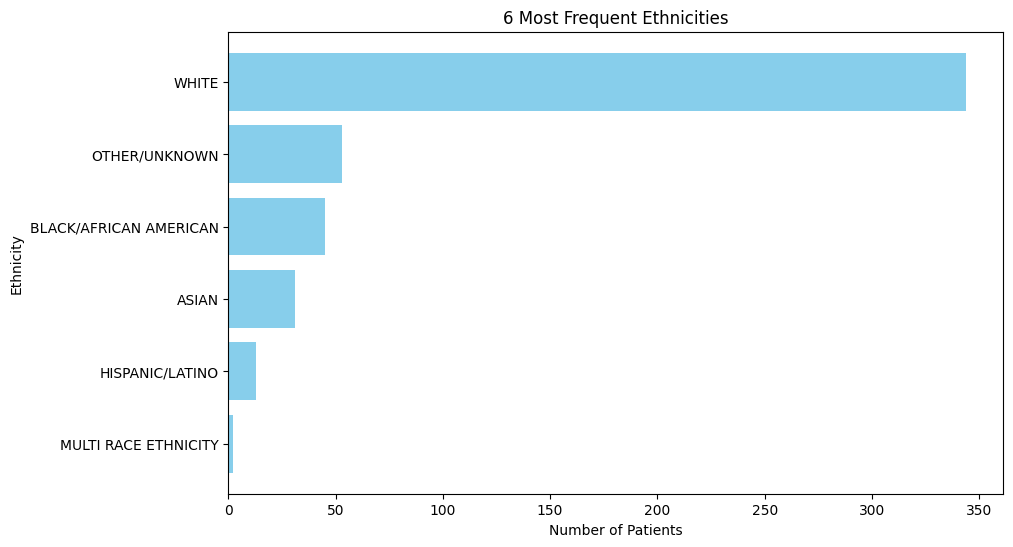

In [174]:
# Computing the value counts of ethnicity using Dask DataFrame and then computing to get the result
et_count = dask_df['ETHNICITY'].value_counts().nlargest(8).compute()

# Plotting the bar chart for the 6 most frequent ethnicities
plt.figure(figsize=(10, 6))
plt.barh(et_count.index, et_count.values, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Ethnicity')
plt.title('6 Most Frequent Ethnicities')
plt.gca().invert_yaxis()
plt.show()

### **RELIGION**
Similar to ethnicity, we observe differences in religion distribution within this dataset.

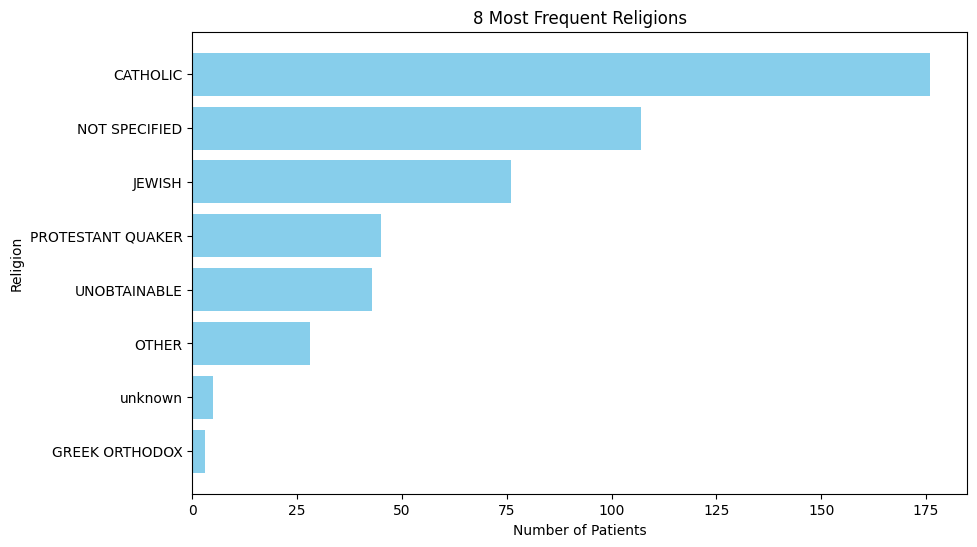

In [175]:
# Computing the value counts of religion using Dask DataFrame and then computing to get the result
religion_count = dask_df['RELIGION'].value_counts().nlargest(8).compute()

# Plotting the bar chart for the 8 most frequent religions
plt.figure(figsize=(10, 6))
plt.barh(religion_count.index, religion_count.values, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Religion')
plt.title('8 Most Frequent Religions')
plt.gca().invert_yaxis()
plt.show()

### **LANGUAGE**
We also observe differences in language distribution within this dataset.

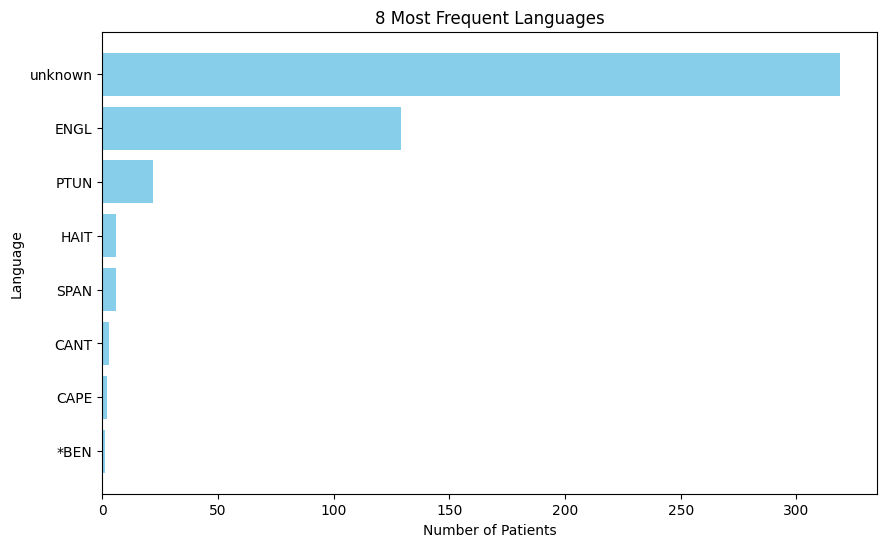

In [176]:
# Computing the value counts of language using Dask DataFrame and then computing to get the result
lang_count = dask_df['LANGUAGE'].value_counts().nlargest(8).compute()

# Plotting the bar chart for the 8 most frequent languages
plt.figure(figsize=(10, 6))
plt.barh(lang_count.index, lang_count.values, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Language')
plt.title('8 Most Frequent Languages')
plt.gca().invert_yaxis()
plt.show()

### **MARITAL STATUS**
Same goes to Maritial Statues, due to the reasons already presented.

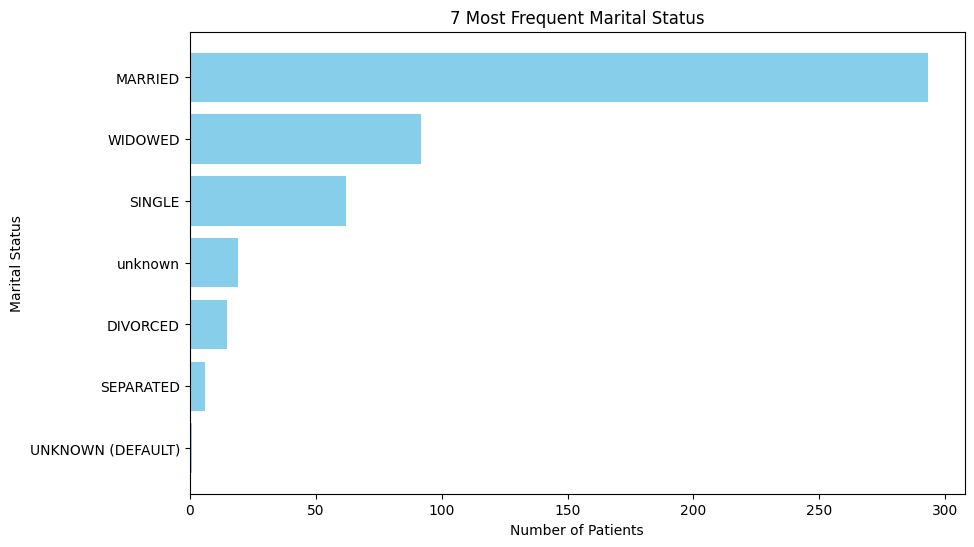

In [177]:
# Computing the value counts of marital status using Dask DataFrame and then computing to get the result
status_count = dask_df['MARITAL_STATUS'].value_counts().nlargest(8).compute()

# Plotting the bar chart for the 8 most frequent marital statuses
plt.figure(figsize=(10, 6))
plt.barh(status_count.index, status_count.values, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Marital Status')
plt.title('7 Most Frequent Marital Status')
plt.gca().invert_yaxis()
plt.show()

### **INSURANCE**
The same occures with the patients' insurance.

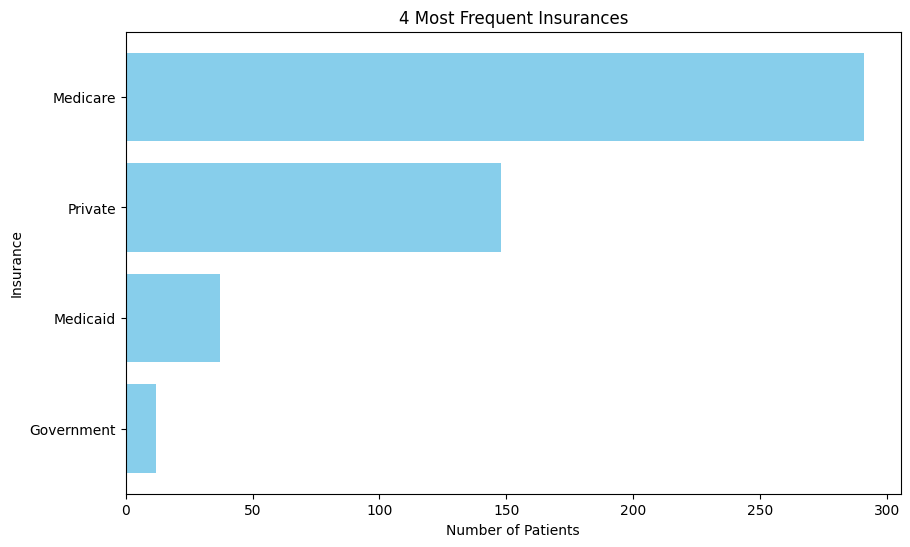

In [178]:
# Computing the value counts of insurance types using Dask DataFrame and then computing to get the result
insurance_count = dask_df['INSURANCE'].value_counts().nlargest(8).compute()

# Plotting the bar chart for the 8 most frequent insurance types
plt.figure(figsize=(10, 6))
plt.barh(insurance_count.index, insurance_count.values, color='skyblue')
plt.xlabel('Number of Patients')
plt.ylabel('Insurance')
plt.title('4 Most Frequent Insurances')
plt.gca().invert_yaxis()
plt.show()

### **AGE**
And finally the age, which presents diferences when compared with the analysis made with BigQuery.

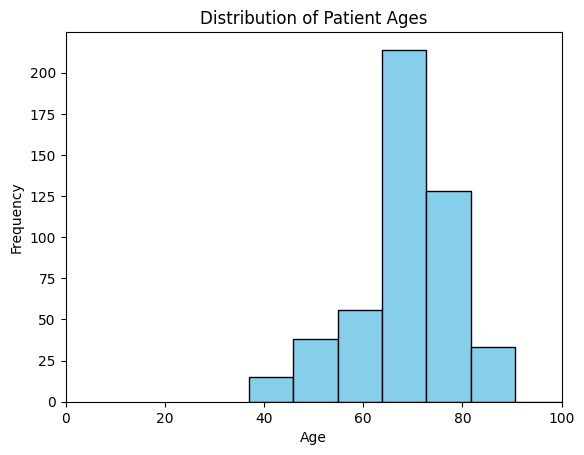

In [179]:
# Plotting the histogram of patient ages using Dask DataFrame
plt.hist(dask_df['AGE'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Ages')
plt.xlim(0, 100)  # Limiting x-axis to ages between 0 and 100
plt.show()

## **Exploring Hospital Admissions**
It occurs the same for the Hospital Admissions exploration

### **Types of Hospital Admissions**
As we can see, there is no Newborns.

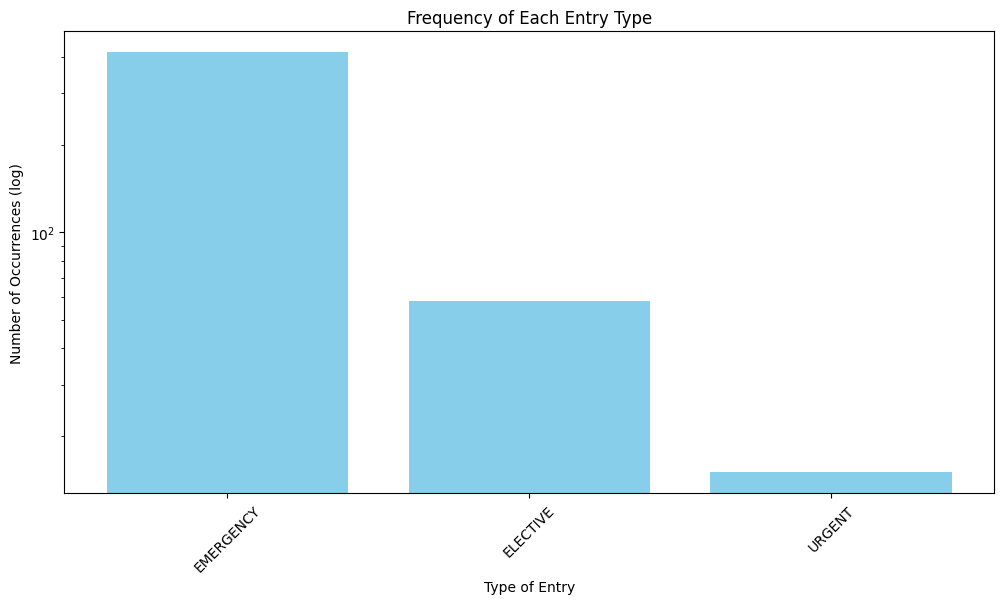

In [180]:
# Plotting the bar chart of admission types using Dask DataFrame
entry_count = dask_df['ADMISSION_TYPE'].value_counts().compute()

plt.figure(figsize=(12, 6))
plt.bar(entry_count.index, entry_count.values, color='skyblue')
plt.yscale('log')  # Using log scale for better visualization of values
plt.xlabel('Type of Entry')
plt.ylabel('Number of Occurrences (log)')
plt.title('Frequency of Each Entry Type')
plt.xticks(rotation=45)
plt.show()

### **Impact of Admission Type on Length of Hospital Stay**
In this sample, the Emergency Admission requires a longer LOS.

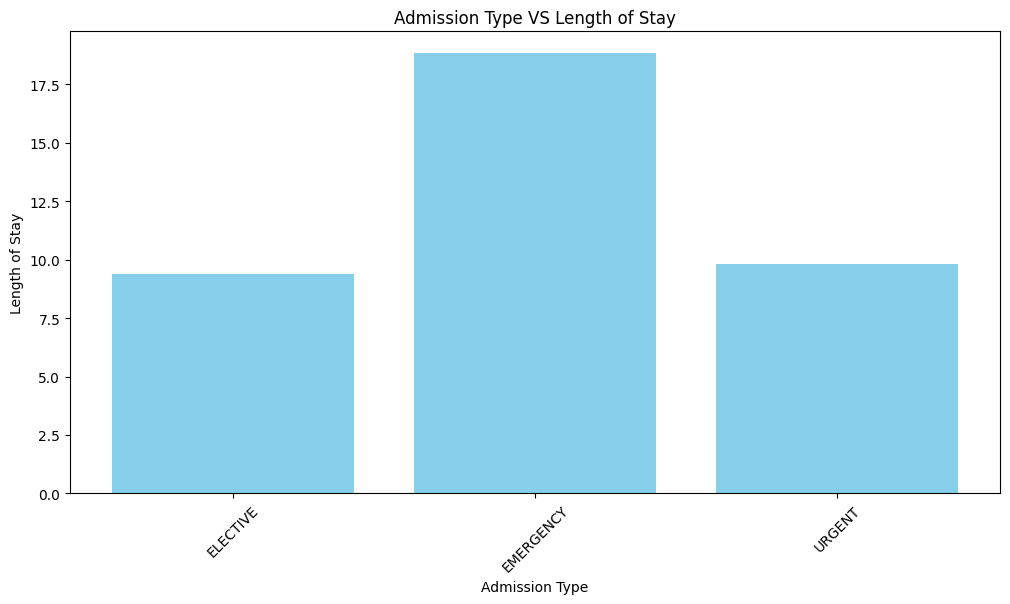

In [181]:
# Querying the mean length of stay for each admission type using Dask DataFrame
query_entries = dask_df.groupby('ADMISSION_TYPE')['LOS'].mean().compute()

# Resetting the index to prepare for plotting
results_df = query_entries.reset_index()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df['ADMISSION_TYPE'], results_df['LOS'], color='skyblue')
plt.xlabel('Admission Type')
plt.ylabel('Length of Stay')
plt.title('Admission Type VS Length of Stay')
plt.xticks(rotation=45)
plt.show()

### **Gender and Length of Stay Analysis**
The gender, once again, does not have an impact on LOS.

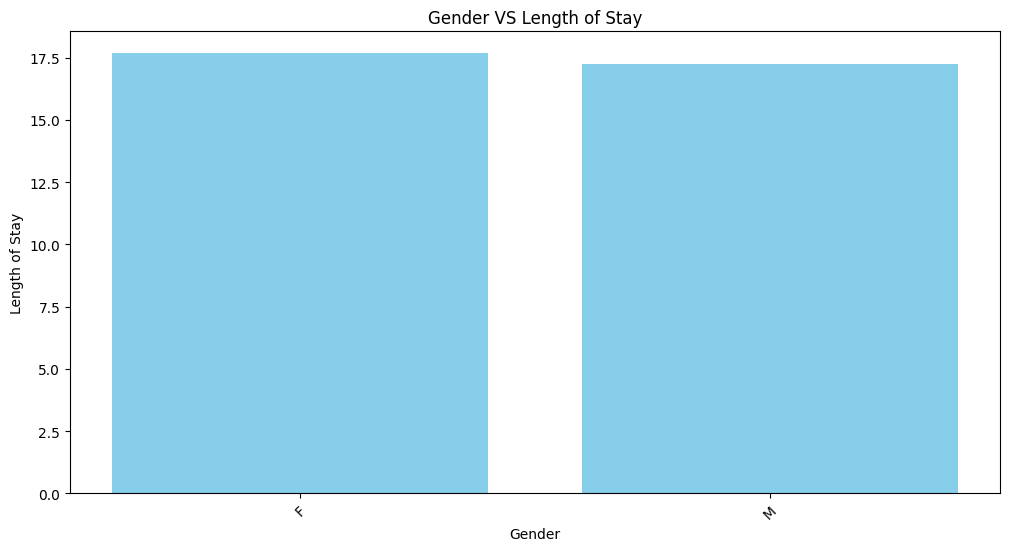

In [182]:
# Querying the mean length of stay for each gender using Dask DataFrame
query_entries2 = dask_df.groupby('GENDER')['LOS'].mean().compute()

# Resetting the index to prepare for plotting
results_df = query_entries2.reset_index()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df['GENDER'], results_df['LOS'], color='skyblue')
plt.xlabel('Gender')
plt.ylabel('Length of Stay')
plt.title('Gender VS Length of Stay')
plt.xticks(rotation=45)
plt.show()

### **Analysis of Error Count and Length of Stay**
In this sample, no errors were made.

In [183]:
# Calculating the count of different error types using Dask DataFrame
error_count = dask_df['ERROR'].value_counts().compute()

# Printing the error count
print(error_count)

ERROR
NaN    433
0.0     55
Name: count, dtype: int64[pyarrow]


### **Number of Hospital Deaths**

Once more, the bar graph shows that the survivals's rate is significantly higher than the deaths. Therefore, we can conclude that this disease has low death rate.

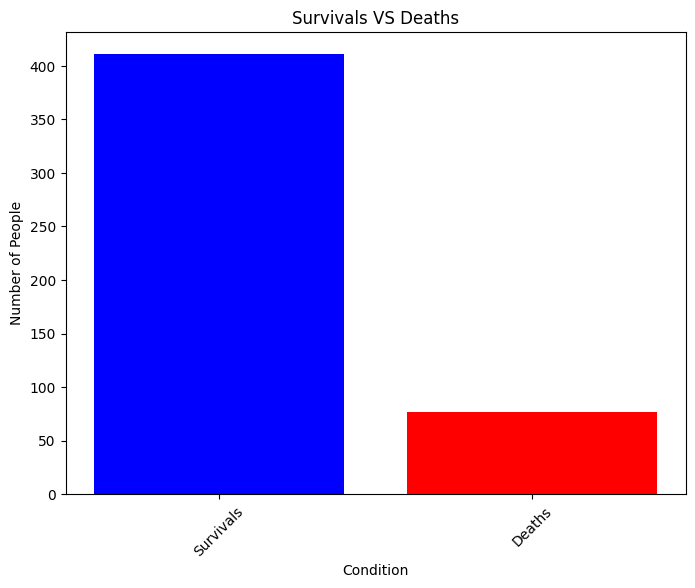

In [185]:
# Filtering Dask DataFrame for hospital deaths and survivals
hosp_deaths_df = dask_df[dask_df['HOSPITAL_EXPIRE_FLAG'] == 1]
surv_hosp_df = dask_df[dask_df['HOSPITAL_EXPIRE_FLAG'] == 0]

# Computing the total number of hospital deaths and survivals
total_deaths = hosp_deaths_df.shape[0].compute()
total_survivals = surv_hosp_df.shape[0].compute()

# Defining value names and heights for plotting
value_names = ['Survivals', 'Deaths']
highs = [total_survivals, total_deaths]

# Defining colors for the bars
colors = ['blue', 'red']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(value_names, highs, color=colors)
plt.xlabel('Condition')
plt.ylabel('Number of People')
plt.title('Survivals VS Deaths')
plt.xticks(rotation=45)
plt.show()

### **Age and Length Of Stay Analysis**

From the plot, it can be observed that there is no strong linear correlation between Age and Length of Stay,as on BigQuery. The data points are quite scattered, indicating a weak relationship. The trend line shows that as age increases, the length of stay slightly increases up to a certain age (around 60-70 years old), after which it stabilizes or slightly decreases. This suggests that while older individuals may tend to have longer stays on average, the relationship is not strong and there is considerable variability.
Therefore, it can be concluded that there are similarities with the BigQuery.

In [186]:
# Defining a function to determine age groups
def age_group(age):
    return (age // 5) * 5

# Applying the age_group function to create a new column 'AGE_GROUP'
dask_df['AGE_GROUP'] = dask_df['AGE'].apply(age_group, meta=('AGE_GROUP', 'int64'))

In [187]:
# Convert Dask DataFrame to pandas DataFrame for further processing
dask_df_pd = dask_df.compute()

<Figure size 1000x600 with 0 Axes>

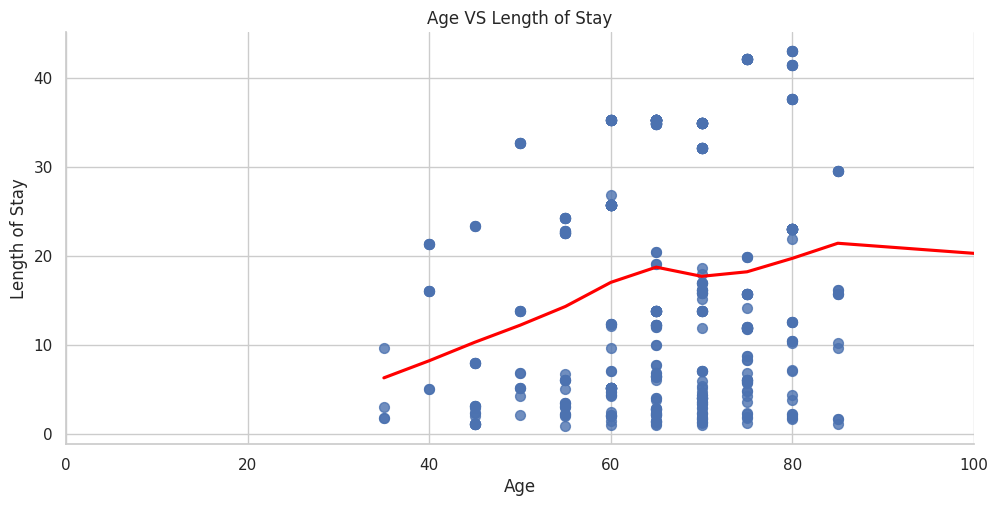

In [188]:
# Set the style of seaborn to 'whitegrid'
sns.set(style="whitegrid")

# Create a scatter plot with a locally weighted scatterplot smoothing (LOWESS) regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='AGE_GROUP', y='LOS', data=dask_df_pd, lowess=True, aspect=2, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel('Age')
plt.ylabel('Length of Stay')
plt.title('Age VS Length of Stay')
plt.xlim(0, 100)
plt.show()

In [189]:
# Remove the 'AGE_GROUP' column from the Dask DataFrame
dask_df = dask_df.drop(columns=['AGE_GROUP'])

# **Machine Learning Model**

The following codes preprocess and split a medical dataset to train and evaluate a model predicting patient length of stay (LOS). The preprocessing step converts the BigFrame DataFrame to a pandas DataFrame, handles datetime columns, and converts categorical variables into dummy variables. After these manipulations, the DataFrame is converted back to BigFrame. A similar aproach is taken in the Dask version.

The data is then split into training, validation, and testing sets based on unique SUBJECT_IDs to prevent data leakage. This ensures that the same patient's data does not appear in multiple sets, maintaining the integrity of the splits. The features and target variable (LOS) are extracted from each of these sets for further processing.

A linear regression model is trained using the training set. The model's performance is evaluated on the validation set through cross-validation, and the mean squared error (MSE) is computed. Finally, the model is tested on the test set, and the MSE is calculated to assess the model's generalization performance. This approach aims to develop a reliable model to predict patient LOS using the processed data.

### **For BigQuery**

In [191]:
# Get the list of columns, removing 'LOS'
columns = [col for col in filtered_features.columns if col != 'LOS']

# Add 'LOS' to the end of the list of columns
columns.append('LOS')

# Reindex the DataFrame with the new order of columns
bigframe = filtered_features.reindex(columns=columns)

print(bigframe)

   SUBJECT_ID HADM_ID ICUSTAY_ID                        DOB  \
0       31260  165822     255228  2045-04-02 00:00:00+00:00   
1       31260  165822     255228  2045-04-02 00:00:00+00:00   
2       31260  165822     255228  2045-04-02 00:00:00+00:00   
3       31260  165822     255228  2045-04-02 00:00:00+00:00   
4       31260  165822     255228  2045-04-02 00:00:00+00:00   
5       31260  165822     255228  2045-04-02 00:00:00+00:00   
6       11861  144257     298894  2105-05-05 00:00:00+00:00   
7       25225  115814     201901  2147-08-13 00:00:00+00:00   
8       25225  115814     201901  2147-08-13 00:00:00+00:00   
9       25225  115814     201901  2147-08-13 00:00:00+00:00   
10      25225  115814     201901  2147-08-13 00:00:00+00:00   
11      25225  115814     201901  2147-08-13 00:00:00+00:00   
12      25225  115814     201901  2147-08-13 00:00:00+00:00   
13      25225  115814     201901  2147-08-13 00:00:00+00:00   
14      25225  115814     201901  2147-08-13 00:00:00+0

Unfortunately, due to the lack of credits, we were not able to run the following cell which makes the preditions for the BigQuery dataframe. 

In [ ]:
def split_data(bf_df, test_size=0.2, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.

    Args:
        bf_df: BigFrame DataFrame.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        tuple: Three DataFrames containing the training, validation, and testing sets.
    """
    df = bf_df.to_pandas()  # Convert BigFrame to pandas DataFrame for processing
    unique_subject_ids = df['SUBJECT_ID'].unique()

    train_ids, test_ids = train_test_split(unique_subject_ids, test_size=test_size)
    train_ids, val_ids = train_test_split(train_ids, test_size=val_size / (1 - test_size))

    train_df = df[df['SUBJECT_ID'].isin(train_ids)]
    val_df = df[df['SUBJECT_ID'].isin(val_ids)]
    test_df = df[df['SUBJECT_ID'].isin(test_ids)]

    return train_df, val_df, test_df

def preprocess_data(bf_df):
    """
    Preprocesses the data by converting it to a pandas DataFrame, performing feature engineering,
    and converting it back to BigFrame.

    Args:
        bf_df: BigFrame DataFrame.

    Returns:
        bf.DataFrame: Preprocessed BigFrame DataFrame.
    """
    df = bf_df.to_pandas()

    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).astype(int)
    df['DEATHTIME'] = df['DEATHTIME'].replace('unknown', pd.NaT)
    df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME']).astype(int)

    df = pd.get_dummies(df, columns=['ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'LABEL', 'ERROR', 'DBSOURCE', 'SHORT_TITLE', 'VALUE'])

    df['SUBJECT_ID'] = df['SUBJECT_ID'].astype(int)
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    df['ICUSTAY_ID'] = df['ICUSTAY_ID'].astype(int)
    df['ITEMID'] = df['ITEMID'].astype(int)
    df['ICD9_CODE'] = df['ICD9_CODE'].astype(int)
    df['SEQ_NUM'] = df['SEQ_NUM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    return bf.from_pandas(df)

# Preprocess the data
preprocessed_bf = preprocess_data(bigframe)

# Convert preprocessed BigFrame to pandas DataFrame for further processing
preprocessed_df = preprocessed_bf.to_pandas()

# Split the data into training, validation, and testing sets
train_df, val_df, test_df = split_data(preprocessed_df)

# Extract features and target variable for training
X_train = train_df.iloc[:, :-1]
y_train = train_df['LOS']

# Extract features and target variable for validation
X_val = val_df.iloc[:, :-1]
y_val = val_df['LOS']

# Extract features and target variable for testing
X_test = test_df.iloc[:, :-1]
y_test = test_df['LOS']

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation to evaluate the model on the validation set
mse_scores = cross_val_score(model, X_val, y_val, scoring='neg_mean_squared_error', cv=5)
mse_mean = -mse_scores.mean()
print('Mean Squared Error on Validation Set (Cross-Validation):', mse_mean)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error on Test Set:', mse_test)

### **Using Other Tools(PySpark, Dask) - Only with the 500-line Dataset**

In [ ]:
def split_data(df, test_size=0.2, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.

    Args:
        df (DataFrame): DataFrame containing the dataset.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        tuple: Three DataFrames containing the training, validation, and testing sets.
    """
    unique_subject_ids = df['SUBJECT_ID'].unique()

    train_ids, test_ids = train_test_split(unique_subject_ids, test_size=test_size)
    train_ids, val_ids = train_test_split(train_ids, test_size=val_size / (1 - test_size))

    train_df = df[df['SUBJECT_ID'].isin(train_ids)]
    val_df = df[df['SUBJECT_ID'].isin(val_ids)]
    test_df = df[df['SUBJECT_ID'].isin(test_ids)]

    return train_df, val_df, test_df

def preprocess_data(df):
    """
    Preprocesses the data by converting it to a pandas DataFrame, performing feature engineering,
    and converting it back to BigFrame.

    Args:
        df (DataFrame): DataFrame containing the dataset.

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).astype(int)

    df['DEATHTIME'] = df['DEATHTIME'].replace('unknown', pd.NaT)

    df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME']).astype(int)

    df = pd.get_dummies(df, columns=['ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'LABEL', 'ERROR', 'DBSOURCE', 'SHORT_TITLE', 'VALUE'])

    df['SUBJECT_ID'] = df['SUBJECT_ID'].astype(int)
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    df['ICUSTAY_ID'] = df['ICUSTAY_ID'].astype(int)
    df['ITEMID'] = df['ITEMID'].astype(int)
    df['ICD9_CODE'] = df['ICD9_CODE'].astype(int)
    df['SEQ_NUM'] = df['SEQ_NUM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    return df

# Preprocess the data
preprocessed_df = preprocess_data(dask_df.compute())

# Split the data into training, validation, and testing sets
train_df, val_df, test_df = split_data(preprocessed_df)

# Extract features and target variable for training
X_train = train_df.iloc[:, :-1]
y_train = train_df['LOS']

# Extract features and target variable for validation
X_val = val_df.iloc[:, :-1]
y_val = val_df['LOS']

# Extract features and target variable for testing
X_test = test_df.iloc[:, :-1]
y_test = test_df['LOS']

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation to evaluate the model on the validation set
mse_scores = cross_val_score(model, X_val, y_val, scoring='neg_mean_squared_error', cv=5)
mse_mean = -mse_scores.mean()
print('Mean Squared Error on Validation Set (Cross-Validation):', mse_mean)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error on Test Set:', mse_test)

Mean Squared Error on Validation Set (Cross-Validation): 220.44475981098134
Mean Squared Error on Test Set: 204.22026173177554


# **Conclusion**

In conclusion, this project provided a comprehensive opportunity to delve into the intricacies of working with large datasets, specifically within the context of ICU patient events. Utilizing a variety of tools and techniques, such as map-reduce, PySpark, BigQuery and Dask we were able to efficiently process and analyze the substantial volume of data contained in the EVENTS.csv.gz file. This hands-on experience underscored the practical utility of big data technologies in managing and extracting meaningful insights from extensive datasets, highlighting their importance in modern data science workflows.

Despite encountering several challenges throughout the process, we successfully performed the required statistical analysis and visualization for each patient, and developed a predictive model for the length of stay. These accomplishments illustrate not only the effectiveness of the tools employed but also our adaptability and problem-solving skills. The knowledge gained from this project is invaluable, as it equips us with the expertise to handle similar big data tasks in the future, ensuring that we can make data-driven decisions with confidence. Overall, the project was a rewarding experience that met all the outlined objectives.